This notebook presents all the supplementary analysis mentioned in the paper.

Click the "Show Code" buttons to see the code associated with each output.

# Preamble

## Libraries

In [1]:
# Data libraries
import pandas as pd
import numpy as np

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

priceformatter = FuncFormatter(lambda x, pos: "${:.0f}".format(x))
import seaborn as sns

sns.set_context("notebook")

# Statistics
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import iqr, mode, kurtosis
from scipy.stats.mstats import zscore
from statsmodels.stats.proportion import proportions_chisquare
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA
from statsmodels.api import OLS, add_constant

# Misc
import warnings

warnings.filterwarnings("ignore")
from IPython.display import Markdown, HTML
from functools import partial
from jinja2 import Environment, ChoiceLoader, FileSystemLoader
from pandas.io.formats.style import Styler

## Misc. Functions

In [2]:
class ResultTableStyler(Styler):
    env = Environment(
        loader=ChoiceLoader(
            [
                FileSystemLoader("../templates"),  # contains ours
                Styler.loader,  # the default
            ]
        )
    )
    template = env.get_template("ResultTableTemplate.tpl")

    def __init__(self, *args):
        super().__init__(*args)
        self.hide_index()
        styles = [
            dict(
                selector="tr > td:nth-child(1)",
                props=[("font-weight", "bold"), ("text-align", "left")],
            ),
            dict(selector="tr:nth-child(2n-1) > td", props=[("font-style", "italic")]),
            dict(
                selector="tr:nth-child(2n) > td", props=[("padding-bottom", "1.75em")]
            ),
            dict(selector="tr", props=[("background-color", "white")]),
            dict(selector="tr:last-child > td", props=[("padding-bottom", "1em")]),
        ]
        self.set_table_styles(styles)


def get_sig_level(x):
    if x < 0.001:
        return " ***"
    elif x < 0.01:
        return " **"
    elif x < 0.05:
        return " *"
    elif x < 0.1:
        return " •"
    else:
        return ""


def weave(*x):
    return np.vstack(x).flatten(order="F")


def gen_output_from_models(models, dv_names, iv_names, params_subset=slice(None)):
    ret = []
    for m in models:
        val = m.params[params_subset].values
        pval = m.pvalues[params_subset].values
        bse = m.bse_fe
        bse = np.append(bse, m.bse_re)
        sem = bse[params_subset]
        sig = np.array([get_sig_level(i) for i in pval])
        val_str = np.array(
            ["{:.3f}{}".format(v, s) for v, s in zip(val[0:-1], sig[0:-1])]
        )
        val_str = np.append(val_str, "{:.3f}".format(m.cov_re["Group"]["Group"]))
        sem_str = np.array(
            ["({:.3f})".format(s) if ~np.isnan(s) else "N.C." for s in sem]
        )
        ret.append(weave(val_str, sem_str))
    cols = np.array([[n, ""] for n in iv_names]).flatten()
    return (
        pd.DataFrame(np.array(ret).T, index=cols, columns=dv_names)
        .reset_index()
        .rename(columns={"index": ""})
    )


def gen_output_from_OLS_models(models, dv_names, iv_names, params_subset=slice(None)):
    ret = []
    for m in models:
        val = m.params[params_subset].values
        pval = m.pvalues[params_subset].values
        bse = m.bse[params_subset].values
        sig = np.array([get_sig_level(i) for i in pval])
        val_str = np.array(["{:.3f}{}".format(v, s) for v, s in zip(val, sig)])
        sem_str = np.array(
            ["({:.3f})".format(s) if ~np.isnan(s) else "N.C." for s in bse]
        )
        ret.append(weave(val_str, sem_str))
    cols = np.array([[n, ""] for n in iv_names]).flatten()
    return (
        pd.DataFrame(np.array(ret).T, index=cols, columns=dv_names)
        .reset_index()
        .rename(columns={"index": ""})
    )

def compute_order_reg_coeff(x):
    ts = x.timestamp.values
    values = x.value.values
    y = (values-values.mean())/values.std()
    return pd.Series(sm.OLS(y, sm.add_constant(ts)).fit().params[1])

def compute_idx_first_value(x):
    firstval = x[x.timestamp == 0].value.values
    values = np.sort(x["value"].values).tolist()
    return values.index(firstval)

def compute_zscore_first_value(x):
    ts = x.timestamp.values
    values = x.value.values
    zscores = (values-values.mean())/values.std()
    return zscores[ts == 0][0]

def lr_test(x, y, d, mu=0, two_sided=True):
    """
    Convert a t-test into a likelihood-ratio test.
    x, y: Two vectors of observations
    d: The difference (x-y) under H1
    mu: The difference (x-y) under H0
    Returns: The likelihood ratio.
    """
    nx = x.shape[0] # Number of observations in X and Y\n,
    ny = y.shape[0]
    sx = x.var(ddof=1) # Variance of X and Y
    sy = y.var(ddof=1)
    y = y + mu # If the null hypothesis is not x == y.
    tval = stats.ttest_ind(x, y, equal_var=False).statistic # t-stat
    ncp = (d/np.sqrt(1/nx + 1/ny)) # Non-centrality parameter for the F-stats
    dof = (((sx/nx + sy/ny)**2)/ # Welch–Satterthwaite equation for the degrees of freedom
           ((sx**2)/((nx**2)*(nx-1)) + (sy**2)/((ny**2)*(ny-1))))
    if two_sided:
        like_h1 = stats.ncf(1, dof, nc=ncp**2).pdf(tval**2) # Likelihood under H1 using the non-central F distribution
        like_h0 = stats.f(1, dof).pdf(tval**2) # Likelihood under H0
    else:
        like_h1 = stats.nct(dof, nc=ncp).pdf(tval)
        like_h0 = stats.t(dof).pdf(tval)
    lratio = like_h1/like_h0 # Likelihood ratio
    return lratio

def lr_test_decision(x, y, d, mu=0, alpha=.05, power=.9, two_sided=True):
    """
    Gives the decision rule of Schnuerch and Erdfelder (2020). 

    x, y: Two vectors of observations
    d: The difference (x-y) under H1
    mu: The difference (x-y) under H0
    alpha: The type I error rate,
    power: The power of the test.

    Returns: The decision rule.
    """
    A = power/alpha
    B = (1-power)/(1-alpha)
    lr = lr_test(x, y, d, mu=mu, two_sided=two_sided)
    if lr >= A:
        return "Accept H1"
    elif lr <= B:
        return "Accept H0"
    else:
        return "Inconclusive"
    
def process_history_data(x):
    """
    Generate the history of values entered by participants.
    To allow for between-participants comparison, this drops the participants who removed values
    at any point in the construction process.
    """
    a = list(map(lambda x: [int(i) for i in x.split(",")], x))
    a = np.array(a)
    if a.shape[0] != 26:
        return None
    else:
        a = np.vstack([[0] * 25, a])
        a = np.diff(a, n=1, axis=0)
        return np.argmax(a, axis=1) * 2
    

## Plotting Functions

In [3]:
def plot_stats_threecells(data, name_manip="sd"):
    df_stats = pd.melt(data, id_vars=["turkid", "is_manipulated", f"{name_manip}_manipulated"],
                   value_vars=["sd", "range", "min", "max", "mean", "mode", "median", "var", "iqr"])
    ylabels = ["Mean", "Median", "Mode", "SD", "Var", "IQR", "Min", "Max", "Range"]
    pal = [(0.4085351787773935, 0.6687427912341408, 0.8145328719723184), "gray", (0.8991926182237601, 0.5144175317185697, 0.4079200307574009)]
    g = sns.FacetGrid(row="variable", col="is_manipulated", hue=f"{name_manip}_manipulated", hue_order=["Low", "Med", "High"],
                      row_order=[ "mean", "median", "mode", "sd", "var", "iqr", "min", "max", "range"],
                      data=df_stats, sharex="row", sharey="row", aspect=2, palette=pal)
    g.map(sns.kdeplot, "value",  alpha=1, bw=2)
    
    g.map(lambda x, *args, **kwargs: plt.axvline(np.mean(x), *args, **kwargs), "value", ls=":")
    axes = g.axes
    g.set_titles("")
    axes[0][0].set_title("Common Distribution")
    axes[0][1].set_title("Manipulated Distribution")
    for ax, ylab in zip(axes, ylabels):
        ax[0].set_yticks([])
        ax[1].set_yticks([])
        ax[0].set_ylabel(ylab)

def plot_stats_twocells(data):
    df_stats = pd.melt(data, id_vars=["turkid", "is_manipulated", "shape_manipulated"],
                   value_vars=["sd", "range", "min", "max", "mean", "mode", "median", "var", "iqr", "kurtosis"])
    ylabels = ["Mean", "Median", "Mode", "SD", "Var", "IQR", "Min", "Max", "Range", "Kurtosis"]
    g = sns.FacetGrid(row="variable", col="is_manipulated", hue="shape_manipulated", hue_order=["Normal", "Uniform"],
                      row_order=[ "mean", "median", "mode", "sd", "var", "iqr", "min", "max", "range", "kurtosis"],
                      data=df_stats, sharex="row", sharey="row", aspect=2)
    g.map(sns.kdeplot, "value",  alpha=1, bw=2)
    
    g.map(lambda x, *args, **kwargs: plt.axvline(np.mean(x), *args, **kwargs), "value", ls=":")
    axes = g.axes
    g.set_titles("")
    axes[0][0].set_title("Common Distribution")
    axes[0][1].set_title("Manipulated Distribution")
    for ax, ylab in zip(axes, ylabels):
        ax[0].set_yticks([])
        ax[1].set_yticks([])
        ax[0].set_ylabel(ylab)
        

def plot_disp_threecells(data):
    fig, ax = plt.subplots(2, 3, figsize=(16, 10))
    colors = sns.color_palette("colorblind")
    bins = np.arange(1, 51, 2)

    titles = [
        "Manipulated Item:\nLow Variance",
        "Manipulated Item:\nModerate Variance",
        "Manipulated Item:\nHigh Variance",
    ]

    # fmt: off
    dists = {
        "Manipulated": {
            "Low": [23, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 
                    26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 28],
            "Med": [17, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 
                    26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 34],
            "High": [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 
                     26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38],
        },
        "Common": {
            "Low": [17, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 
                    26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 34],
            "Med": [17, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 
                    26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 34],
            "High": [17, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 
                     26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 34],   
        }
    }
    # fmt: on

    xrange = np.arange(1, 50, 0.1)

    for i, disttype in enumerate(["Common", "Manipulated"]):
        for j, cond in enumerate(["Low", "Med", "High"]):
            # True dist
            tdist = dists[disttype][cond]
            sigma = np.array(tdist).std()
            ## Distplot
            z = stats.norm.pdf(xrange, 25, sigma)
            ax[i][j].plot(xrange, z, **{"lw": 2, "color": "black"})
            ## CI
            inflim = 25 - sigma * 1.96
            suplim = 25 + sigma * 1.96
            ax[i][j].axvline(inflim, 0, 0.8, ls=":", color="black")
            ax[i][j].axvline(suplim, 0, 0.8, ls=":", color="black")

            # Individual dists
            pdists = data[(data.sd_manipulated == cond) & (data.distname == disttype)]
            ## Distplot
            gb = pdists.groupby(["turkid"])
            f = partial(
                sns.distplot,
                hist=False,
                kde_kws={"lw": 1, "color": colors[0], "bw": 2, "alpha": 0.2},
                ax=ax[i][j],
            )
            gb.value.apply(lambda x: f(x))

            # Aggregate dist
            ## Distplot
            st = gb.value.agg(**{"M": np.mean, "SD": np.std}).mean()
            mu, sigma = st.M, st.SD
            ax[i][j].plot(
                xrange,
                stats.norm.pdf(xrange, loc=25, scale=sigma),
                **{"lw": 3, "color": colors[1], "alpha": 1, "zorder": 100}
            )
            ## CI
            inflim = 25 - sigma * 1.96
            suplim = 25 + sigma * 1.96
            ax[i][j].axvline(inflim, 0, 0.8, ls=":", color=colors[1])
            ax[i][j].axvline(suplim, 0, 0.8, ls=":", color=colors[1])

            # Cleaning
            ax[i][j].set_ylim(0, 0.4)
            ax[i][j].set_xlim(0, 51)
            sns.despine()
            ax[0][j].set_title(titles[j])
            ax[i][j].set_xticks(np.linspace(5, 45, 5))
            ax[i][j].set_yticks([])
            ax[i][j].set_xlabel("")
            ax[i][j].xaxis.set_major_formatter(priceformatter)

    # Legend
    ax[0][0].set_ylabel("Price Distributions for\n'Common' Item", size=12)
    ax[1][0].set_ylabel("Price Distributions for\n'Manipulated' Item", size=12)
    custom_lines = [
        Line2D([0], [0], color=colors[0], lw=1, alpha=0.4),
        Line2D([0], [0], color=colors[1], lw=2),
        Line2D([0], [0], color="black", lw=2),
        Line2D([0], [0], color="white", lw=0),
        Line2D([0], [0], color=colors[1], lw=2, ls=":"),
        Line2D([0], [0], color="black", lw=2, ls=":"),
    ]
    custom_labels = [
        "Individual Responses",
        "Gaussian Average Distribution (True Mean-Centered)",
        "True Distribution",
        "",
        "95% CI of Gaussian Average",
        "95% CI of True Distribution",
    ]
    ax[1][1].legend(
        custom_lines,
        custom_labels,
        ncol=2,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.4),
    )

def plot_disp_twocells(data):
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))
    colors = sns.color_palette("colorblind")
    bins = np.arange(1, 51, 2)
    titles = ["Normal", "Uniform"]
    xrange = np.arange(1, 50, 0.1)
    
    dists = {
        'Uniform': np.array([ 
            # fmt: off
            18, 18, 18,
            20, 20, 20,
            22, 22, 22,
            24, 24, 24,
            26, 26, 26,
            28, 28, 28,
            30, 30, 30,
            32, 32, 32,
            # fmt: on
        ]),

        'Normal': np.array([
            # fmt: off
            18,
            20,
            22, 22, 22, 22,
            24, 24, 24, 24, 24, 24,
            26, 26, 26, 26, 26, 26,
            28, 28, 28, 28, 
            30,
            32,
            # fmt: off
    ])}

    xrange = np.arange(1, 50, 0.1)
    for i, disttype in enumerate(["Common", "Manipulated"]):
        for j, shape in enumerate(["Normal", "Uniform"]):
            # True dist
            tdist = dists[shape] if disttype == "Manipulated" else dists["Normal"]
            mu = np.array(tdist).mean()
            sigma = np.array(tdist).std()
            
            ## Distplot
            z = stats.norm.pdf(xrange, 25, sigma)
            ax[i][j].plot(xrange, z, **{"lw": 2, "color": "black"})
            ## CI
            inflim = 25 - sigma * 1.96
            suplim = 25 + sigma * 1.96
            ax[i][j].axvline(inflim, 0, 0.8, ls=":", color="black")
            ax[i][j].axvline(suplim, 0, 0.8, ls=":", color="black")
            
            # Individual dists
            pdists = data[(data.shape_manipulated == shape) & (data.legend_manipulated == disttype)]
            ## Distplot
            gb = pdists.groupby(["turkid"])
            f = partial(
                sns.distplot,
                hist=False,
                kde_kws={"lw": 1, "color": colors[0], "bw": 2, "alpha": 0.2},
                ax=ax[i][j],
            )
            gb.value.apply(lambda x: f(x))

            # Aggregate dist
            ## Distplot
            st = gb.value.agg(**{"M": np.mean, "SD": np.std}).mean()
            mu, sigma = st.M, st.SD
            ax[i][j].plot(
                xrange,
                stats.norm.pdf(xrange, loc=25, scale=sigma),
                **{"lw": 3, "color": colors[1], "alpha": 1, "zorder": 100}
            )
            ## CI
            inflim = 25 - sigma * 1.96
            suplim = 25 + sigma * 1.96
            ax[i][j].axvline(inflim, 0, 0.8, ls=":", color=colors[1])
            ax[i][j].axvline(suplim, 0, 0.8, ls=":", color=colors[1])

            # Cleaning
            ax[i][j].set_ylim(0, 0.4)
            ax[i][j].set_xlim(0, 51)
            sns.despine()
            ax[0][j].set_title(titles[j])
            ax[i][j].set_xticks(np.linspace(5, 45, 5))
            ax[i][j].set_yticks([])
            ax[i][j].set_xlabel("")
            ax[i][j].xaxis.set_major_formatter(priceformatter)

    # Legend
    ax[0][0].set_ylabel("Price Distributions for\n'Common' Item", size=12)
    ax[1][0].set_ylabel("Price Distributions for\n'Manipulated' Item", size=12)
    custom_lines = [
        Line2D([0], [0], color=colors[0], lw=1, alpha=0.4),
        Line2D([0], [0], color=colors[1], lw=2),
        Line2D([0], [0], color="black", lw=2),
        Line2D([0], [0], color="white", lw=0),
        Line2D([0], [0], color=colors[1], lw=2, ls=":"),
        Line2D([0], [0], color="black", lw=2, ls=":"),
    ]
    custom_labels = [
        "Individual Responses",
        "Gaussian Average Distribution (True Mean-Centered)",
        "True Distribution",
        "",
        "95% CI of Gaussian Average",
        "95% CI of True Distribution",
    ]
    ax[1][1].legend(
        custom_lines,
        custom_labels,
        ncol=2,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.4),
    )


def plot_avg_threecells(data):
    fig, ax = plt.subplots(2, 3, figsize=(16, 10))
    colors = sns.color_palette("colorblind")
    bins = np.arange(1, 51, 2)
    titles = [
        "Manipulated Item:\nLow Mean",
        "Manipulated Item:\nModerate Mean",
        "Manipulated Item:\nHigh Mean",
    ]

    # fmt: off
    dists = {
        "Manipulated": {
            "Low": [6, 7, 9, 9, 10, 11, 12, 12, 13, 13, 14, 14, 15, 
                    16, 16, 17, 17, 18, 18, 19, 20, 21, 21, 23, 24],
            "Med": [16, 17, 19, 19, 20, 21, 22, 22, 23, 23, 24, 24, 
                    25, 26, 26, 27, 27, 28, 28, 29, 30, 31, 31, 33, 34],
            "High": [26, 27, 29, 29, 30, 31, 32, 32, 33, 33, 34, 34, 
                     35, 36, 36, 37, 37, 38, 38, 39, 40, 41, 41, 43, 44],
        },
        "Common": {
            "Low": [16, 17, 19, 19, 20, 21, 22, 22, 23, 23, 24, 24, 
                    25, 26, 26, 27, 27, 28, 28, 29, 30, 31, 31, 33, 34],
            "Med": [16, 17, 19, 19, 20, 21, 22, 22, 23, 23, 24, 24, 
                    25, 26, 26, 27, 27, 28, 28, 29, 30, 31, 31, 33, 34],
            "High": [16, 17, 19, 19, 20, 21, 22, 22, 23, 23, 24, 24, 
                     25, 26, 26, 27, 27, 28, 28, 29, 30, 31, 31, 33, 34],   
        }
    }
    # fmt: on

    xrange = np.arange(1, 50, 0.1)
    for i, disttype in enumerate(["Common", "Manipulated"]):
        for j, cond in enumerate(["Low", "Med", "High"]):
            # True dist
            tdist = dists[disttype][cond]
            mu = np.array(tdist).mean()
            sigma = np.array(tdist).std()
            ## Distplot
            z = stats.norm.pdf(xrange, mu, sigma)
            ax[i][j].plot(xrange, z, **{"lw": 2, "color": "black"})
            ## Mean
            ax[i][j].axvline(mu, 0, 0.8, ls=":", color="black")

            # Individual dists
            pdists = data[(data.mean_manipulated == cond) & (data.distname == disttype)]
            ## Distplot
            gb = pdists.groupby(["turkid"])
            f = partial(
                sns.distplot,
                hist=False,
                kde_kws={"lw": 1, "color": colors[0], "bw": 2, "alpha": 0.2},
                ax=ax[i][j],
            )
            gb.value.apply(lambda x: f(x))

            # Aggregate dist
            ## Distplot
            st = gb.value.agg(**{"M": np.mean, "SD": np.std}).mean()
            mu, sigma = st.M, st.SD
            ax[i][j].plot(
                xrange,
                stats.norm.pdf(xrange, loc=mu, scale=sigma),
                **{"lw": 3, "color": colors[1], "alpha": 1, "zorder": 100}
            )
            ## CI
            ax[i][j].axvline(mu, 0, 0.8, ls=":", color=colors[1])

            # Cleaning
            ax[i][j].set_ylim(0, 0.25)
            ax[i][j].set_xlim(0, 51)
            sns.despine()
            ax[0][j].set_title(titles[j], size=12)
            ax[i][j].set_xticks(np.linspace(5, 45, 5))
            ax[i][j].set_yticks([])
            ax[i][j].set_xlabel("")
            ax[i][j].xaxis.set_major_formatter(priceformatter)

    ax[0][0].set_ylabel("Price Distributions for\n'Common' Item", size=12)
    ax[1][0].set_ylabel("Price Distributions for\n'Manipulated' Item", size=12)
    custom_lines = [
        Line2D([0], [0], color=colors[0], lw=1, alpha=0.4),
        Line2D([0], [0], color=colors[1], lw=2),
        Line2D([0], [0], color="black", lw=2),
        Line2D([0], [0], color="white", lw=0),
        Line2D([0], [0], color=colors[1], lw=2, ls=":"),
        Line2D([0], [0], color="black", lw=2, ls=":"),
    ]
    custom_labels = [
        "Reported Distributions",
        "Gaussian Average Distribution",
        "True Distribution",
        "",
        "Average Reported Mean",
        "Mean of True Distribution",
    ]
    ax[1][1].legend(
        custom_lines,
        custom_labels,
        ncol=2,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.4),
    )


def plot_disp_fourcells(data, studynum=9):
    fig, ax = plt.subplots(2, 2, figsize=(16, 10))
    colors = sns.color_palette("colorblind")
    bins = np.arange(1, 51, 2)
    titles = ["Given Item: Low Var", "Given Item: High Var"]
    xrange = np.arange(1, 50, 0.1)
    
    # fmt: off
    if studynum == 9:
        dists = {
            'Low': np.array([8, 10, 10, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12, 
                            12, 12, 12, 12, 12, 12, 14, 14, 14, 14, 14, 14, 16]),
            'High': np.array([2, 4, 4, 6, 6, 8, 8, 8, 10, 10, 10, 12, 12, 12, 
                            12, 14, 14, 14, 16, 16, 16, 18, 18, 20, 20, 22])
        }
    else:
        dists = {
            "Low": np.array([18.0, 19.0, 19.0, 20.0, 20.0, 21.0, 21.0, 21.0, 
                             22.0, 22.0, 22.0, 23.0, 23.0, 23.0, 24.0, 24.0, 24.0,
                             25.0, 25.0, 25.0, 26.0, 26.0, 27.0, 27.0, 28.0])+2,
            "High": np.array([10.0, 13.0, 15.0, 17.0, 18.0, 20.0, 21.0, 22.0, 24.0,
                              25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 34.0,
                              35.0, 36.0, 38.0, 39.0, 41.0, 43.0, 46.0])-3
        }
    # fmt: on

    for i, other in enumerate(["Low", "High"]):
        for j, focal in enumerate(["Low", "High"]):
            # True dist
            tdist = dists[focal]
            mu = np.array(tdist).mean()
            sigma = np.array(tdist).std()
            ## Distplot
            z = stats.norm.pdf(xrange, 25, sigma)
            ax[i][j].plot(xrange, z, **{"lw": 2, "color": "black"})
            ## CI
            inflim = 25 - sigma * 1.96
            suplim = 25 + sigma * 1.96
            ax[i][j].axvline(inflim, 0, 0.8, ls=":", color="black")
            ax[i][j].axvline(suplim, 0, 0.8, ls=":", color="black")

            # Individual dists
            pdists = data[(data.sd_focal == focal) & (data.sd_other == other)]
            ## Distplot
            gb = pdists.groupby(["turkid", "item"])
            f = partial(
                sns.distplot,
                hist=False,
                kde_kws={"lw": 1, "color": colors[0], "bw": 2, "alpha": 0.2},
                ax=ax[i][j],
            )
            gb.value.apply(lambda x: f(x - x.mean() + 25))

            # Aggregate dist
            ## Distplot
            st = gb.value.agg(**{"M": np.mean, "SD": np.std}).mean()
            mu, sigma = st.M, st.SD
            ax[i][j].plot(
                xrange,
                stats.norm.pdf(xrange, loc=25, scale=sigma),
                **{"lw": 3, "color": colors[1], "alpha": 1, "zorder": 100}
            )
            ## CI
            inflim = 25 - sigma * 1.96
            suplim = 25 + sigma * 1.96
            ax[i][j].axvline(inflim, 0, 0.8, ls=":", color=colors[1])
            ax[i][j].axvline(suplim, 0, 0.8, ls=":", color=colors[1])

            # Cleaning
            ax[i][j].set_ylim(0, 0.25)
            ax[i][j].set_xlim(0, 51)

            sns.despine()
            ax[0][j].set_title(titles[j], size=12)
            ax[i][j].set_xticks(np.linspace(5, 45, 5))
            ax[i][j].set_yticks([])
            ax[i][j].set_xlabel("")
            ax[i][j].xaxis.set_major_formatter(priceformatter)

    ax[0][0].set_ylabel("Other Item: Low Var", size=12)
    ax[1][0].set_ylabel("Other Item: High Var", size=12)
    custom_lines = [
        Line2D([0], [0], color=colors[0], lw=1, alpha=0.4),
        Line2D([0], [0], color=colors[1], lw=2),
        Line2D([0], [0], color="black", lw=2),
        Line2D([0], [0], color="white", lw=0),
        Line2D([0], [0], color=colors[1], lw=2, ls=":"),
        Line2D([0], [0], color="black", lw=2, ls=":"),
    ]
    custom_labels = [
        "Reported Distributions (True Mean-Centered)",
        "Gaussian Average Distribution (True Mean-Centered)",
        "True Distribution",
        "",
        "95% CI of Gaussian Average",
        "95% CI of True Distribution",
    ]
    ax[1][0].legend(
        custom_lines,
        custom_labels,
        ncol=2,
        loc="lower center",
        bbox_to_anchor=(1.2, -0.4),
    )


def annotate_reg_coeff(x, y, *args, pos=(0, 0), **kwargs):
    pval = sm.OLS(y, sm.add_constant(x)).fit().pvalues[1]
    plt.annotate(f"p = {pval:.3f}", pos, ha="center", va="center")

## Data loading

In [4]:
# Study 2
df2_dists = pd.read_csv("../Data/Study 2/LongData.csv")
df2_dists["distname"] = df2_dists.is_manipulated.apply(
    lambda x: "Manipulated" if x == True else "Common"
)

df2 = (
    df2_dists.groupby(
        ["turkid", "is_manipulated", "sd_manipulated"]
    )
    .value.agg(
        **{
            "sd": np.std,
            "range": lambda x: np.max(x) - np.min(x),
            "min": np.min,
            "max": np.max,
            "mean": np.mean,
            "mode": lambda x: mode(x)[0],
            "median": np.median,
            "var": lambda x: np.std(x) ** 2,
            "iqr": iqr,
        }
    )
    .reset_index()
)


# Study 3
df3_dists = pd.read_csv("../Data/Study 3/LongData.csv")
df3_dists["distname"] = df3_dists.is_manipulated.apply(
    lambda x: "Manipulated" if x == True else "Common"
)

df3 = (
    df3_dists.groupby(
        ["turkid", "is_manipulated", "sd_manipulated"]
    )
    .value.agg(
        **{
            "sd": np.std,
            "range": lambda x: np.max(x) - np.min(x),
            "min": np.min,
            "max": np.max,
            "mean": np.mean,
            "mode": lambda x: mode(x)[0],
            "median": np.median,
            "var": lambda x: np.std(x) ** 2,
            "iqr": iqr,
        }
    )
    .reset_index()
)


# Study 8
df8_dists = pd.read_csv("../Data/Study 8/LongData.csv")
df8_dists["distname"] = df8_dists.is_manipulated.apply(
    lambda x: "Manipulated" if x == True else "Common"
)

df8 = (
    df8_dists.groupby(
        ["turkid", "is_manipulated", "mean_manipulated"]
    )
    .value.agg(
        **{
            "sd": np.std,
            "range": lambda x: np.max(x) - np.min(x),
            "min": np.min,
            "max": np.max,
            "mean": np.mean,
            "mode": lambda x: mode(x)[0],
            "median": np.median,
            "var": lambda x: np.std(x) ** 2,
            "iqr": iqr,
        }
    )
    .reset_index()
)

# Study 9
df9_dists = pd.read_csv("../Data/Study 9/LongData.csv")

df9 = (
    df9_dists.groupby(["turkid", "pid", "item", "sd_focal", "sd_other"])
    .value.agg(
        **{
            "sd": np.std,
            "range": lambda x: np.max(x) - np.min(x),
            "min": np.min,
            "max": np.max,
            "mean": np.mean,
            "mode": lambda x: mode(x)[0],
            "median": np.median,
            "var": lambda x: np.std(x) ** 2,
            "iqr": iqr,
        }
    )
    .reset_index()
)

# Study 10
df10_dists = pd.read_csv("../Data/Study 10/LongData.csv")
df10_dists_sim = df10_dists.loc[df10_dists.similarity == "Similar"]
df10_dists_dissim = df10_dists.loc[df10_dists.similarity == "Dissimilar"]

df10 = (
    df10_dists.groupby(["turkid", "pid", "item", "sd_focal", "sd_other", "similarity"])
    .value.agg(
        **{
            "sd": np.std,
            "range": lambda x: np.max(x) - np.min(x),
            "min": np.min,
            "max": np.max,
            "mean": np.mean,
            "mode": lambda x: mode(x)[0],
            "median": np.median,
            "var": lambda x: np.std(x) ** 2,
            "iqr": iqr,
        }
    )
    .reset_index()
)

# Appendix Study 1 - Range and Variance Study

dfa1_dists = pd.read_csv("../Data/Study A1/LongData.csv")
dfa1_dists["legend_manipulated"] = dfa1_dists.is_manipulated.map(
    {False: "Common", True: "Manipulated"}
)
dfa1_dists["shape_manipulated"] = dfa1_dists.shape_manipulated.map(
    {"Same": "Normal", "Uniform": "Uniform"}
)

dfa1 = (
    dfa1_dists.groupby(
        [
            "pid",
            "turkid",
            "wine",
            "is_manipulated",
            "shape_manipulated",
            "legend_manipulated"
        ]
    )
    .value.agg(
        **{
            "sd": np.std,
            "range": lambda x: np.max(x) - np.min(x),
            "min": np.min,
            "max": np.max,
            "mean": np.mean,
            "mode": lambda x: mode(x)[0],
            "median": np.median,
            "var": lambda x: np.std(x) ** 2,
            "iqr": iqr,
            "kurtosis": lambda x: kurtosis(x, fisher=False),
        }
    )
    .reset_index()
)



# Study 2 - History of distributions
df2_clean = pd.read_pickle("../Data/Study 2/CleanData.pickle")
df2_clean["history_values"] = df2_clean.history.apply(process_history_data)
df2_clean["true_sd"] = df2_clean.apply(
    lambda x: 4.5
    if ((x.is_distractor == False) or (x.sd_distractor == "Med"))
    else 1.1
    if x.sd_distractor == "Low"
    else 7.5,
    axis=1,
)
df2_clean["final_sd"] = df2_clean.dist.apply(lambda x: np.std(x))
df2_clean["final_mean"] = df2_clean.dist.apply(lambda x: np.mean(x))
df2_clean["abs_diff_sd"] = np.abs(df2_clean["true_sd"] - df2_clean.final_sd)
df2_clean["abs_diff_m"] = np.abs(25 - df2_clean.final_mean)

df2_hist = (
    df2_clean.set_index(
        [
            "pid",
            "is_distractor",
            "sd_distractor",
            "abs_diff_sd",
            "abs_diff_m",
            "final_mean",
            "final_sd",
        ]
    )["history_values"]
    .apply(pd.Series)
    .stack()
    .reset_index()
)
df2_hist.columns = [
    "pid",
    "is_manipulated",
    "sd_manipulated",
    "abs_diff_sd",
    "abs_diff_m",
    "final_mean",
    "final_sd",
    "timestamp",
    "value",
]

idx_first_value = (
    df2_hist.groupby(
        ["pid", "is_manipulated"]
    )
    .apply(compute_idx_first_value)
    .reset_index()
)

df2_hist = pd.merge(df2_hist, idx_first_value).rename(columns={0: "idx_first_value"})

zscore_first_value = (
    df2_hist.groupby(
        ["pid", "is_manipulated"]
    )
    .apply(compute_zscore_first_value)
    .reset_index()
)

df2_hist = pd.merge(df2_hist, zscore_first_value).rename(columns={0: "zscore_first_value"})


reg_coeff_order = (df2_hist
                   .groupby(["pid", "is_manipulated"])
                   .apply(compute_order_reg_coeff)
                   .reset_index())

df2_hist = pd.merge(df2_hist, reg_coeff_order).rename(columns={0: "reg_coeff_order"})


df2_parts = (
    df2_hist.groupby(["pid", "is_manipulated", "sd_manipulated"]).mean().reset_index()
)


# Supplementary Results for Distribution Builder Studies

## Data Transformation of Distribution Builder Data

In those studies, participants reported two distributions on two separate distribution builders, by spreading a fixed number of markers (representing bottles of wine) across different possible buckets (representing prices). 

![Demo](../Figures/DistbuilderDemo/demo.png)

In the example above, the participant has allocated:
* 1 marker to price \$13
* 1 marker to price \$15
* 2 markers to price \$17
* 5 markers to price \$19
* 8 markers to price \$21
* 5 markers to price \$23
* 2 markers to price \$25
* 1 marker to price \$27
* 1 marker to price \$29

The distribution corresponding to this allocation is therefore: 

[13, 15, 17, 17, 19, 19, 19, 19, 19, 21, 21, 21, 21, 21, 21, 21, 21, 23, 23, 23, 23, 23, 25, 25, 27, 29].

We then calculated, for each of the two distributions reported by participants, summary statistics of interest (e.g. the standard deviation in Study 2 and 3, the mean in Study 8). 

Those summary statistics constitute our dependent variables.

## Study 2

Participants saw two distributions: one for pillows and the other for blankets.
* One distribution (the "Common" distribution) had constant dispersion across subjects ($\sigma = 4.5$)
* The other (the "Manipulated" distribution) had a variable level of dispersion manipulated between subjects ($\sigma_{L} = 1.1$, $\sigma_{M} = 4.5$, $\sigma_{H} = 7.5$)

All distributions had a constant mean ($\mu = 25$).

The graph below describes the distributions reported by participants:

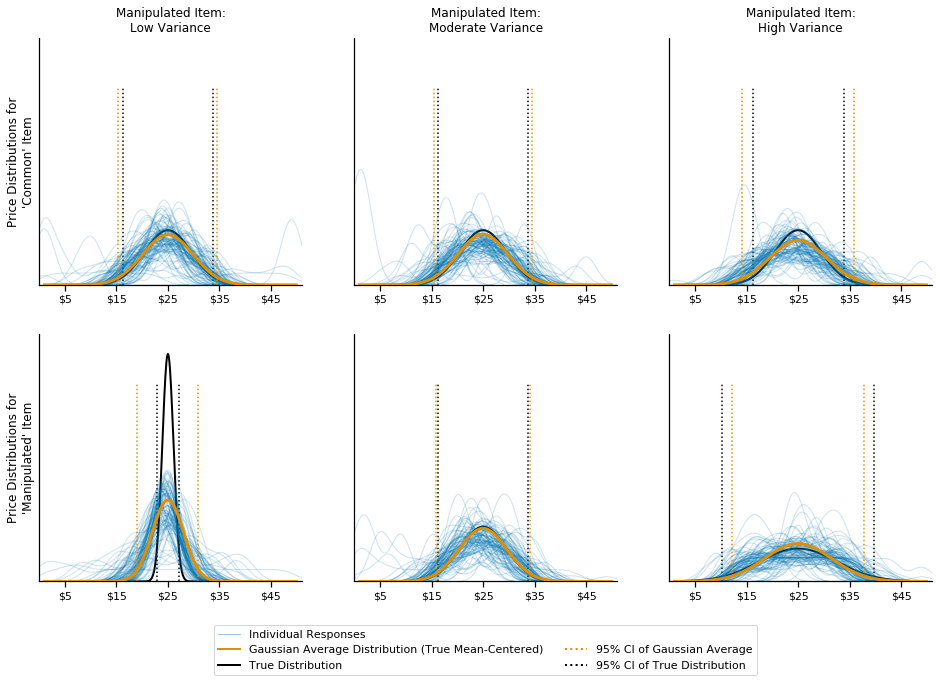

In [5]:
plot_disp_threecells(df2_dists)

For each distribution reported by participants, we computed the following statistics of interest: 
* Mean
* Median
* Mode
* SD 
* Variance
* Interquartile Range (IQR)
* Minimum
* Maximum

We regressed those statistics on the following predictors:
* One factor indicating the type of the distribution (Dummy-coded: "Manipulated vs. Common")
* One factor indicating the amount of dispersion in the "Manipulated" distribution (Dummy-coded: "High vs. Moderate" and "Low vs. Moderate")
* The interaction of those factors
* A random intercept for each participant

The conditional effects for each of the two categories (manipulated vs. common) are presented in the table below:

In [6]:
r = []
for depvar in ["mean", "median", "mode", "sd", "var", "iqr", "min", "max", "range"]:
    c = smf.mixedlm(
        f"{depvar} ~ -1+C(is_manipulated, Treatment(0))+C(sd_manipulated, Treatment(2)):C(is_manipulated, Treatment(0))",
        df2,
        groups=df2.turkid,
    ).fit()
    r.append(c)


t = gen_output_from_models(
    r,
    ["Mean", "Median", "Mode", "SD", "Var", "IQR", "Min", "Max", "Range"],
    [
        "Common: Moderate",
        "Manipulated: Moderate",
        "Common: High vs. Moderate",
        "Common: Low vs. Moderate",
        "Manipulated: High vs. Moderate",
        "Manipulated: Low vs. Moderate",
        "Participants Random Effect Var",
    ],
)

ResultTableStyler(t)

We observe the following:
* People's impression of dispersion for the manipulated distribution is appropriately affected by the amount of dispersion presented in this distribution.
* A High (vs. Medium) amount of dispersion in the manipulated distribution has a significant impact on the subjective amount of dispersion for the common distribution. This effect is directionally consistent across different operationalizations of dispersion (SD, var, IQR, min, max, range). 


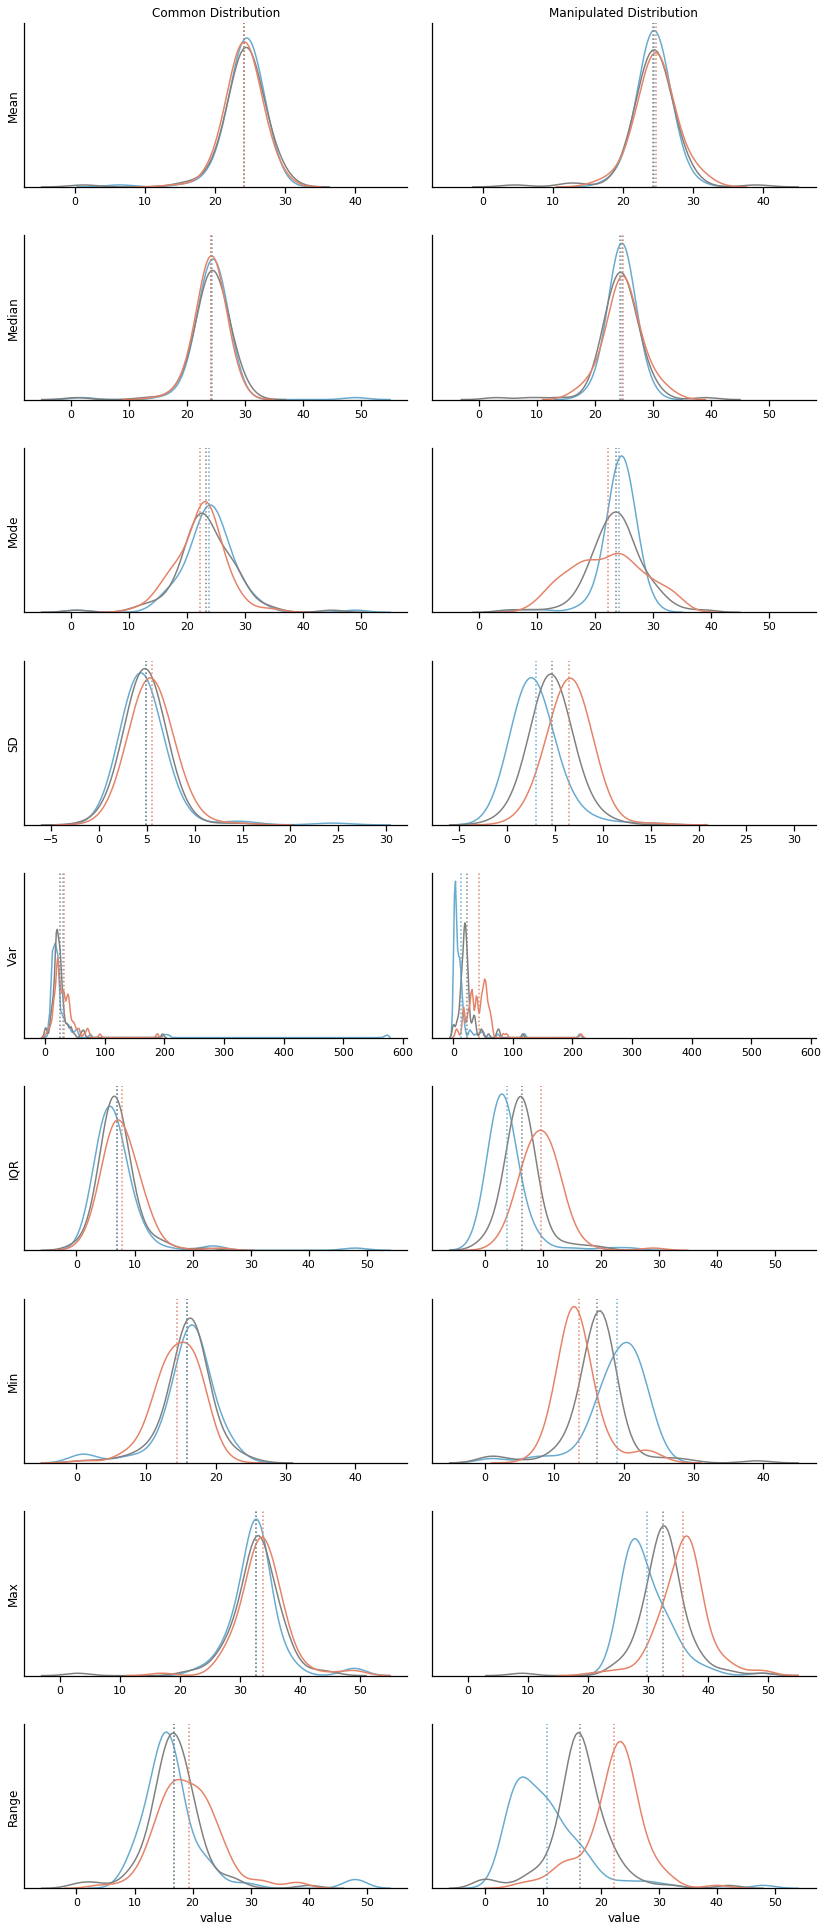

In [7]:
plot_stats_threecells(df2)

## Study 3

Participants saw two distributions: one for white wines and the other for red wines.
* One distribution (the "Common" distribution) had constant dispersion across subjects ($\sigma = 4.5$)
* The other (the "Manipulated" distribution) had a variable level of dispersion manipulated between subjects ($\sigma_{L} = 1.1$, $\sigma_{M} = 4.5$, $\sigma_{H} = 7.5$)

All distributions had a constant mean ($\mu = 25$).

This time, the distributions were presented in a blocked order. 

The graph below describes the distributions reported by participants:

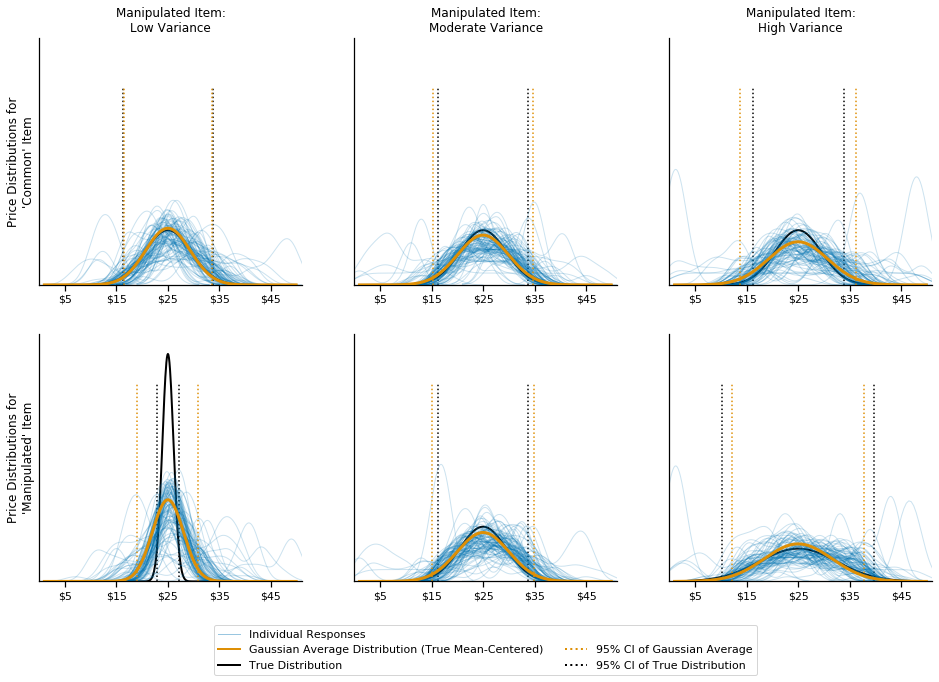

In [8]:
plot_disp_threecells(df3_dists)

For each distribution reported by participants, we computed the following statistics of interest: 
* Mean
* Median
* Mode
* SD 
* Variance
* Interquartile Range (IQR)
* Minimum
* Maximum

We regressed those statistics on the following predictors:
* One factor indicating the type of the distribution (Dummy-coded: "Manipulated vs. Common")
* One factor indicating the amount of dispersion in the "Manipulated" distribution (Dummy-coded: "High vs. Moderate" and "Low vs. Moderate")
* The interaction of those factors
* A random intercept for each participant

The conditional effects for each of the two categories (manipulated vs. common) are presented in the table below:

In [9]:
r = []
for depvar in ["mean", "median", "mode", "sd", "var", "iqr", "min", "max", "range"]:
    c = smf.mixedlm(
        f"{depvar} ~ -1+C(is_manipulated, Treatment(0))+C(sd_manipulated, Treatment(2)):C(is_manipulated, Treatment(0))",
        df3,
        groups=df3.turkid,
    ).fit()
    r.append(c)


t = gen_output_from_models(
    r,
    ["Mean", "Median", "Mode", "SD", "Var", "IQR", "Min", "Max", "Range"],
    [
        "Common: Moderate",
        "Manipulated: Moderate",
        "Common: High vs. Moderate",
        "Common: Low vs. Moderate",
        "Manipulated: High vs. Moderate",
        "Manipulated: Low vs. Moderate",
        "Participants Random Effect Var",
    ],
)

ResultTableStyler(t)

We observe the following:
* People's impression of dispersion for the manipulated distribution is appropriately affected by the amount of dispersion presented in this distribution.
* A High (vs. Medium) amount of dispersion in the manipulated distribution has a significant impact on the subjective amount of dispersion for the common distribution. This effect is directionally consistent across different operationalizations of dispersion (SD, var, IQR, min, max, range). 
* A Low (vs. Medium) has a much smaller impact on the subjective amount of dispersion for the common distribution.

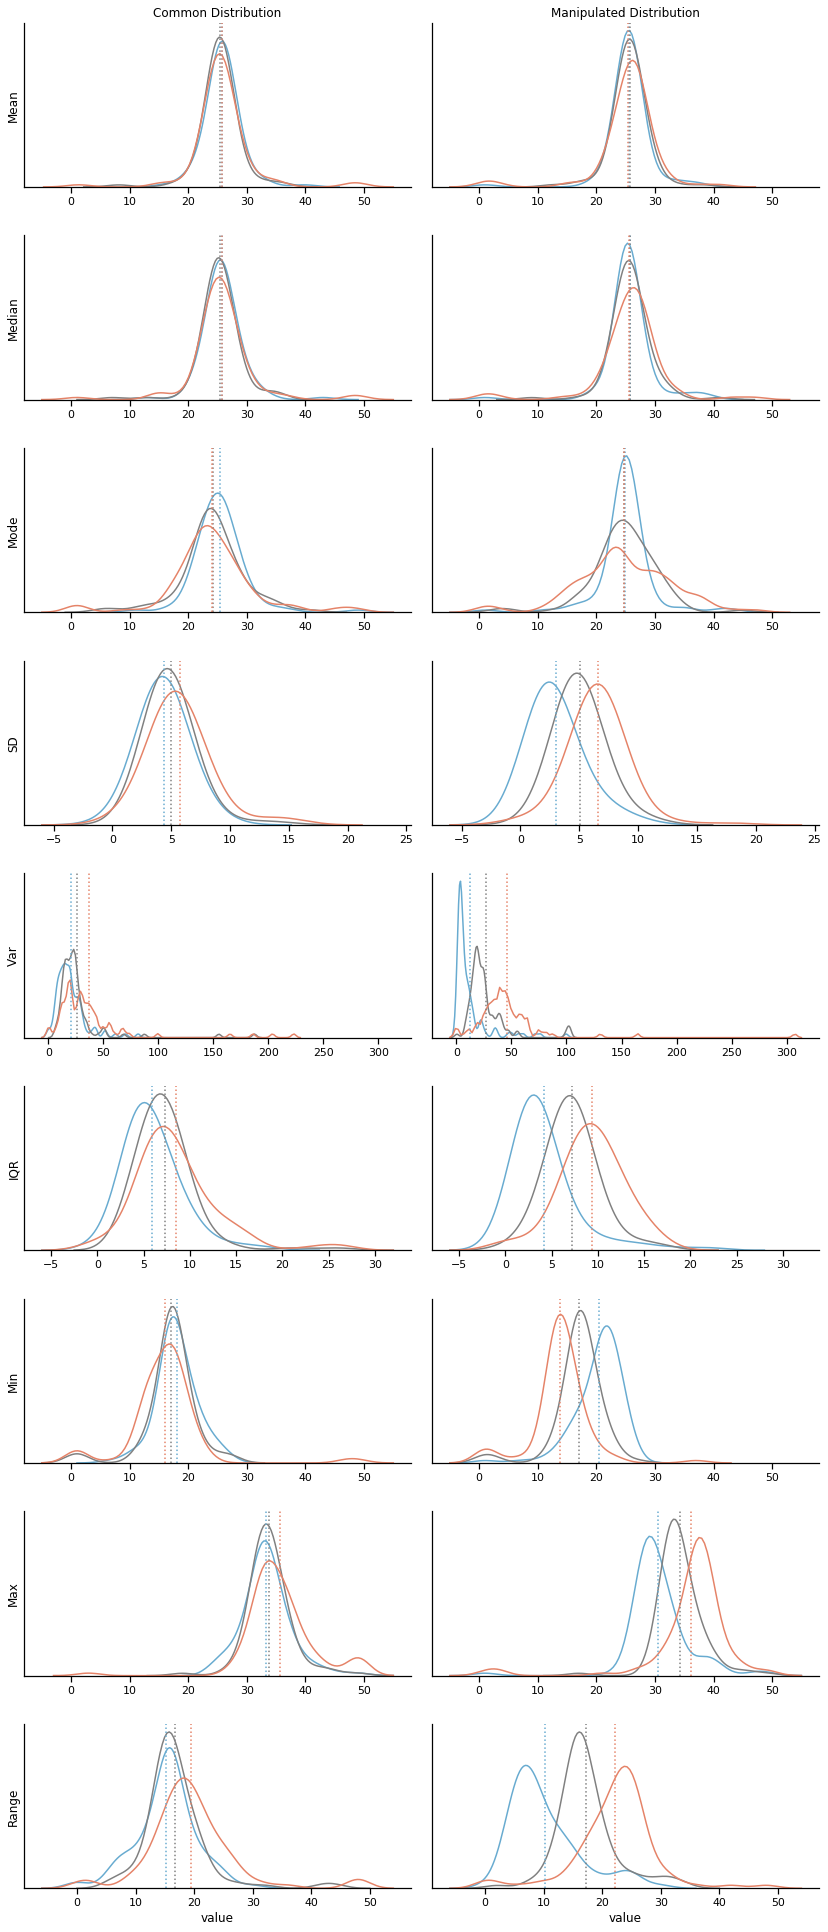

In [10]:
plot_stats_threecells(df3)

## Study 8

Participants saw two distributions of wine prices: one for red wines and the other for white wines.
* One distribution (the "Common" distribution) had constant mean across subjects ($\mu = 25$)
* The other (the "Manipulated" distribution) had a variable mean manipulated between subjects ($\mu_{L} = 15$, $\mu_{M} = 25$, $\mu_{H} = 35$)

All distributions had a constant amount of dispersion ($\sigma = 4.5$).

The graph below describes the distributions reported by participants:

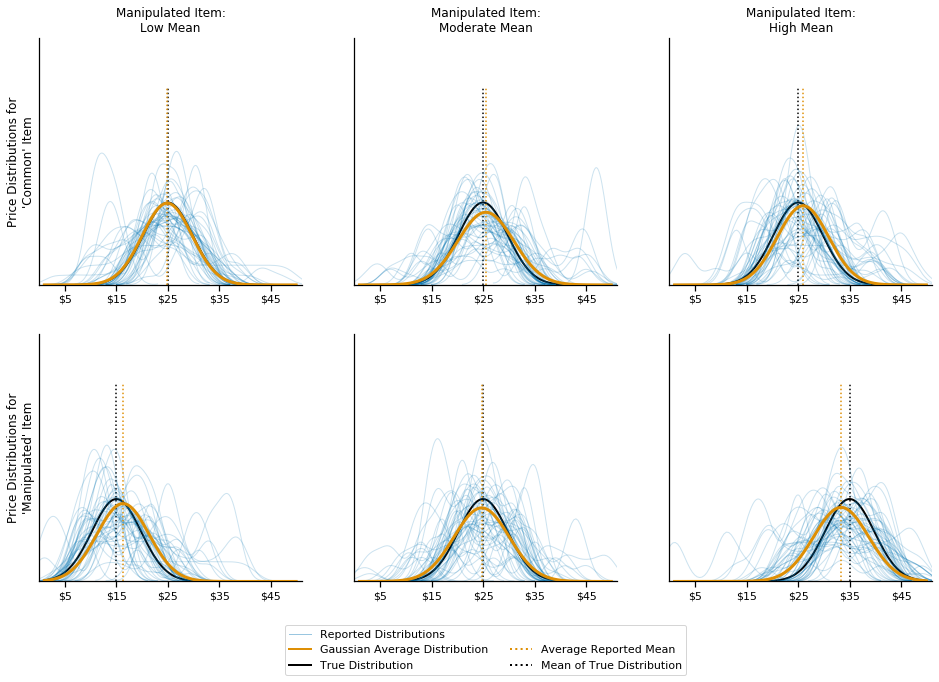

In [11]:
plot_avg_threecells(df8_dists)

For each distribution reported by participants, we computed the following statistics of interest: 
* Mean
* Median
* Mode
* SD 
* Variance
* Interquartile Range (IQR)
* Minimum
* Maximum

We regressed those statistics on the following predictors:
* One factor indicating the type of the distribution (Dummy-coded: "Manipulated vs. Common")
* One factor indicating the mean of the "Manipulated" distribution (Dummy-coded: "High vs. Moderate" and "Low vs. Moderate")
* The interaction of those factors
* A random intercept for each participant

The conditional effects for each of the two categories (manipulated vs. common) are presented in the table below:

In [12]:
r = []
for depvar in ["mean", "median", "mode", "sd", "var", "iqr", "min", "max", "range"]:
    c = smf.mixedlm(
        f"{depvar} ~ -1+C(is_manipulated, Treatment(0))+C(mean_manipulated, Treatment(2)):C(is_manipulated, Treatment(0))",
        df8,
        groups=df8.turkid,
    ).fit()
    r.append(c)

t = gen_output_from_models(
    r,
    ["Mean", "Median", "Mode", "SD", "Var", "IQR", "Min", "Max", "Range"],
    [
        "Common: Moderate",
        "Manipulated: Moderate",
        "Common: High vs. Moderate",
        "Common: Low vs. Moderate",
        "Manipulated: High vs. Moderate",
        "Manipulated: Low vs. Moderate",
        "Participants Random Effect Var",
    ],
)

ResultTableStyler(t)

We observe the following:
* The true mean of the manipulated distribution has a significant impact on the mean of the manipulated distribution reported by participants. 
* In contrast, the mean, median or mode of the common distribution that participants report are not affected by the mean of the "Manipulated" distribution, which suggests that participants made a distinction between the central tendency of the two distributions.
* Mean-independent statistics of dispersion (SD, var, IQR and range) are also not affected by our manipulations of the mean, which is inconsistent with what an exemplar-based model of judgment would have predicted.

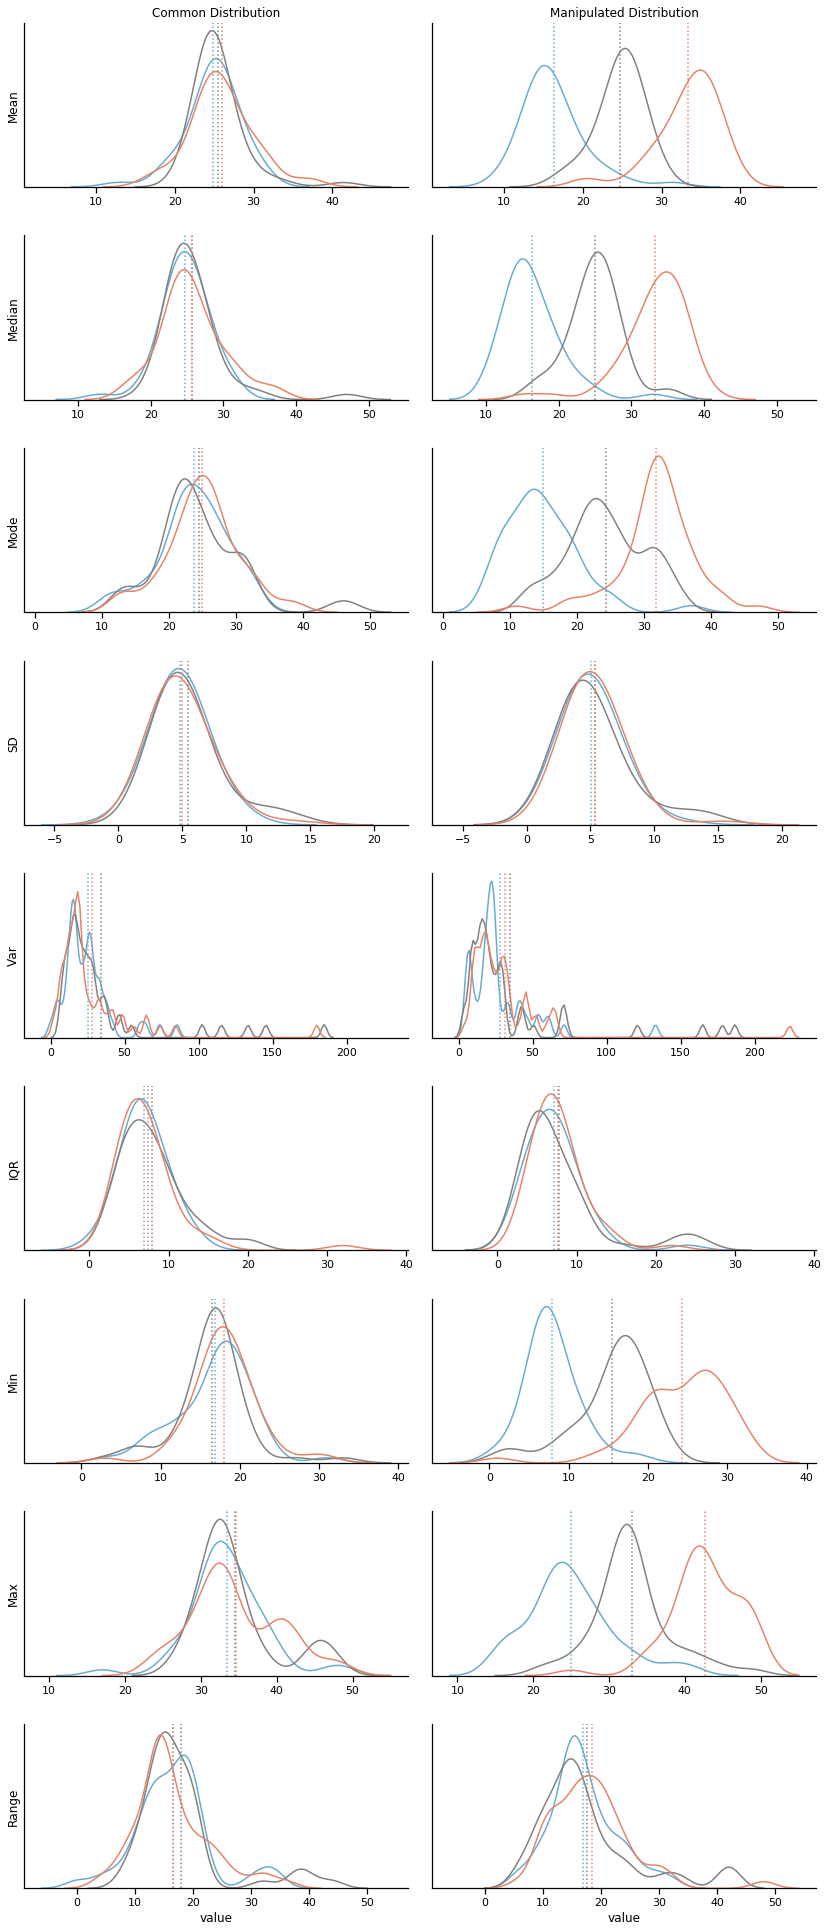

In [13]:
plot_stats_threecells(df8, name_manip="mean")

## Study 9

Participants saw two distributions of wine prices: one for red wines and the other for white wines. 
* The variance of each distribution was orthogonally manipulated between-subjects to be "Low" ($\sigma_{L} = 1.78$) or "High" ($\sigma_{H} = 5.37$)
* The mean price of each distribution was held constant between-subjects, and was such that the two distributions did not overlap: ($\mu_{\text{White}} = 12$, $\mu_{\text{Red}} = 38$)

The graph below describes the (mean-centered) distributions reported by participants:

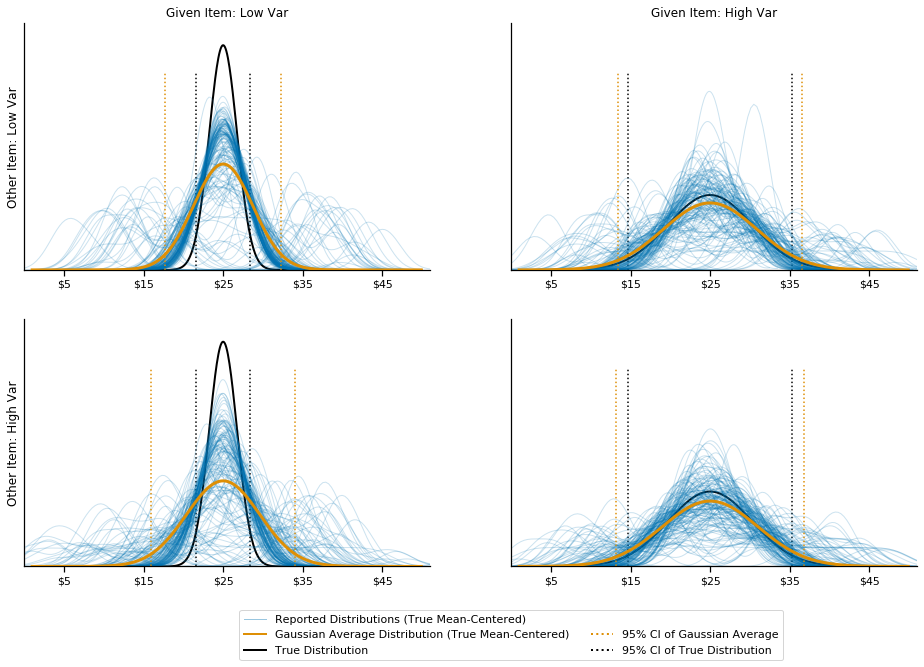

In [14]:
plot_disp_fourcells(df9_dists, studynum=9)


For each distribution reported by participants, we computed the following statistics of interest: 
* Mean
* Median
* Mode
* SD 
* Variance
* Interquartile Range (IQR)
* Minimum
* Maximum


We regressed those statistics on the following predictors:
* One factor indicating the dispersion of this "Given" distribution ("Low": -0.5, "High": 0.5)
* One factor indicating the dispersion of the "Other" distribution that the participant learned ("Low": -0.5, "High": 0.5)
* The interaction of those factors
* A random intercept for each participant

The results are presented in the table below:

In [15]:
r = []
for depvar in ["mean", "median", "mode", "sd", "var", "iqr", "min", "max", "range"]:
    c = smf.mixedlm(
        f"{depvar} ~ C(sd_focal, Diff, levels=['Low', 'High'])*C(sd_other, Diff, levels=['Low', 'High'])",
        df9,
        groups=df9.turkid,
    ).fit()
    r.append(c)

t = gen_output_from_models(
    r,
    ["Mean", "Median", "Mode", "SD", "Var", "IQR", "Min", "Max", "Range"],
    [
        "Intercept",
        "Given Item: High vs. Low SD",
        "Other Item: High vs. Low SD",
        "Cumulative Impact of High vs. Low SD",
        "Participants Random Effect Var",
    ],
)

ResultTableStyler(t)

As the distributions of Means, Median, Mode, Maximum, and Minimum are bimodal, some convergence issues arise when estimating parameters in the mixed linear model (indicated by N.C. in the table).

An OLS specification gives similar results:

In [16]:
r_OLS = []
for depvar in ["mean", "median", "mode", "sd", "var", "iqr", "min", "max", "range"]:
    c = smf.ols(
        f"{depvar} ~ C(sd_focal, Diff, levels=['Low', 'High'])*C(sd_other, Diff, levels=['Low', 'High'])",
        df9,
    ).fit()
    r_OLS.append(c)

t_OLS = gen_output_from_OLS_models(
    r_OLS,
    ["Mean", "Median", "Mode", "SD", "Var", "IQR", "Min", "Max", "Range"],
    [
        "Intercept",
        "Given Item: High vs. Low SD",
        "Other Item: High vs. Low SD",
        "Cumulative Impact of High vs. Low SD",
    ],
)

ResultTableStyler(t_OLS)

We replicate the dispersion spillover, in a context where the two distributions do not overlap:
* The dispersion of a "Given" distribution has a significant impact on the dispersion of prices reported by participants for this "Given" distribution. 
* The dispersion of the "Other" distribution that was simultaneously presented also affects the dispersion of prices reported by participants.
* Those effects are directionally consistent across different operationalizations of dispersion (SD, var, IQR, min, max, range).

## Study 10

Participants saw two distributions of prices.

* We manipulated between-subjects the label assigned to each distribution so that they describe "Similar" products (white wines/red wines) or "Dissimilar" products (smartphone cases/red wines)
* The variance of each distribution was orthogonally manipulated between-subjects to be "Low" ($\sigma_{L} = 2.7$) or "High" ($\sigma_{H} = 9.6$)
* The mean price of each distribution was held constant between-subjects ($\mu_{\text{White/Smartphones}} = 23$, $\mu_{\text{Red}} = 28$)

The graph below describes the distributions reported by participants in the "Similar" and "Dissimilar" conditions:


### Similar items

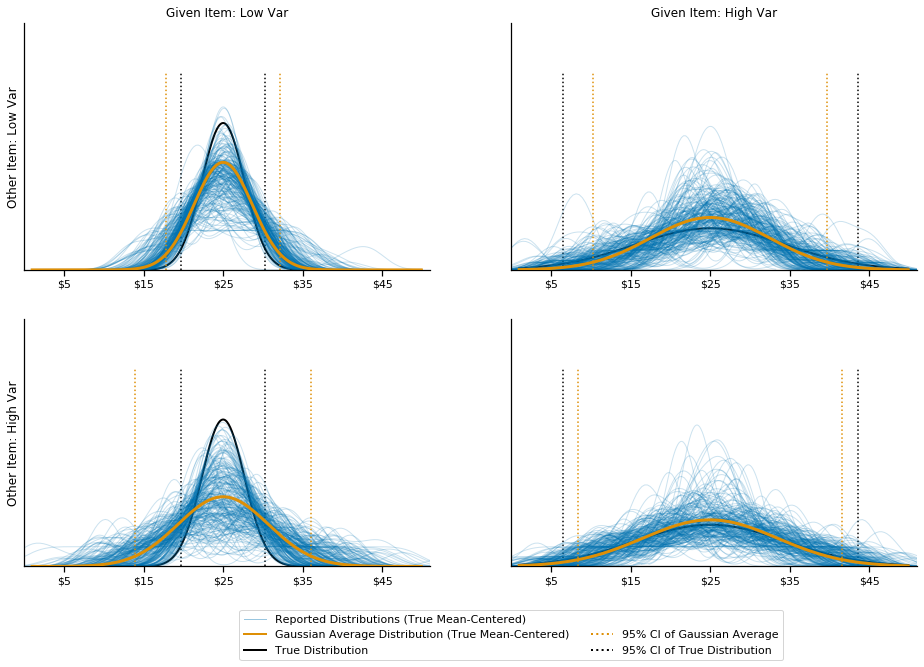

In [17]:
plot_disp_fourcells(df10_dists_sim, studynum=10)

### Dissimilar items

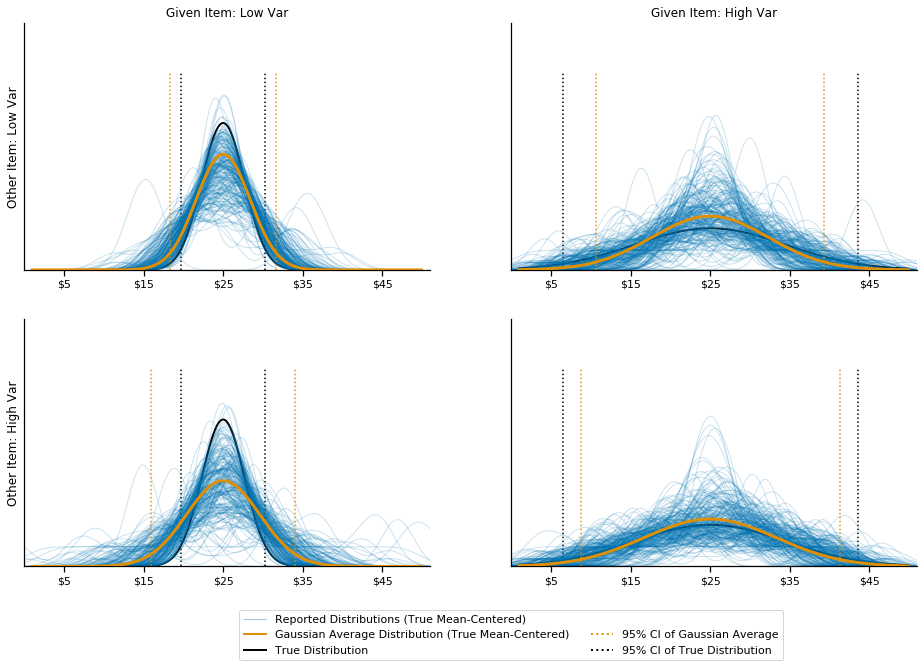

In [18]:
plot_disp_fourcells(df10_dists_dissim, studynum=10)

For each distribution reported by participants, we computed the following statistics of interest: 
* Mean
* Median
* Mode
* SD 
* Variance
* Interquartile Range (IQR)
* Minimum
* Maximum


We regressed those statistics on the following predictors:
* One factor indicating the dispersion of this "Given" distribution ("Low": -0.5, "High": 0.5)
* One factor indicating the dispersion of the "Other" distribution that the participant learned ("Low": -0.5, "High": 0.5)
* The interaction of those factors
* A random intercept for each participant

The results are presented in the table below:

In [19]:
r = []
for depvar in ["mean", "median", "mode", "sd", "var", "iqr", "min", "max", "range"]:
    c = smf.mixedlm(
        f"{depvar} ~ \
    C(sd_focal, Diff, levels=['Low', 'High'])*\
    C(sd_other, Diff, levels=['Low', 'High'])*\
    C(similarity, Diff, levels=['Dissimilar', 'Similar'])",
        df10,
        groups=df10.turkid,
    ).fit()
    r.append(c)

t = gen_output_from_models(
    r,
    ["Mean", "Median", "Mode", "SD", "Var", "IQR", "Min", "Max", "Range"],
    [
        "Intercept",
        "Given Item: High vs. Low SD",
        "Other Item: High vs. Low SD",
        "Cumulative Impact of High vs. Low SD",
        "Similarity: Similar vs. Dissimilar",
        "Given Item × Similarity",
        "Other Item × Similarity",
        "Cumulative Impact × Similarity",
        "Participants Random Effects Var",
    ],
)

ResultTableStyler(t)

We observe the following:
* The dispersion of a "Given" distribution has a significant impact on the dispersion of prices reported by participants for this "Given" distribution. 
* The dispersion of the "Other" distribution that was simultaneously presented also affects the dispersion of prices reported by participants.
* The impact of the "Given" distribution is weaker (stronger) for items that are similar (dissimilar)
* The impact of the "Other" distribution is stronger (weaker) for items that are similar (dissimilar)
* Those effects are directionally consistent across different operationalizations of dispersion (SD, var, IQR, min, max, range).

# Interpretations of the Null Effect reported in Study 8

In Study 8, we find that when two distributions have different (vs. identical means):
* Participants' perception of the mean are not significantly influenced by the mean of the other distribution
* The range of the distributions reported by participants is not wider

In this section, we interpret those null effects by comparing them to the effects of the "dispersion spillover" observed in study 2.

## Interpreting the Null Effect of "No Mean Spillover"

In [20]:
df2["sd_d"] = df2["sd"]/df2["sd"].std(ddof=1)
gb_stats = df2.groupby(["is_manipulated", "sd_manipulated"]).mean()["sd_d"]
inc_sd_manipulated = gb_stats.loc[(True, "High")] - gb_stats.loc[(True, "Med")]
inc_sd_common = gb_stats.loc[(False, "High")] - gb_stats.loc[(False, "Med")]
sd_ratio = inc_sd_common/inc_sd_manipulated

df8["mean_d"] = df8["mean"]/df8["mean"].std(ddof=1)
gb_stats = df8.groupby(["is_manipulated", "mean_manipulated"]).mean()["mean_d"]
inc_m_manipulated = gb_stats.loc[(True, "High")] - gb_stats.loc[(True, "Med")]
inc_m_common = gb_stats.loc[(False, "High")] - gb_stats.loc[(False, "Med")]
m_ratio = inc_m_common/inc_m_manipulated


common_resp_high = df8[(df8.is_manipulated == False) & (df8.mean_manipulated == "High")]["mean_d"].values
common_resp_med = df8[(df8.is_manipulated == False) & (df8.mean_manipulated == "Med")]["mean_d"].values

lr = lr_test(common_resp_high, common_resp_med, inc_m_manipulated*sd_ratio, two_sided=True)
decision = lr_test_decision(common_resp_high, common_resp_med, inc_m_manipulated*sd_ratio, 0, power=.90, two_sided=True)

Markdown(
f"""
In study 2, we find that when the dispersion of the manipulated distribution is high (vs. medium):
* It increases the perceived standard deviation of the *manipulated* distribution by d = {inc_sd_manipulated:.2f}.
* It increases the perceived standard deviation of the *common* distribution by d = {inc_sd_common:.2f}.

The ratio of those values is $R_\sigma$ = {sd_ratio:.2f}. It suggests the magnitude of the "dispersion spillover" is roughly 1/3 of 
the increase in perceived dispersion for manipulated distribution.

This gives us one credible benchmark against which to compare the "mean spillover": Do we find that the "mean spillover" is
1/3 of the increase in mean for the manipulated distribution in study 8?

In study 8, we find that when the mean of the manipulated distribution is high (vs. medium):
* It increases the perceived mean of the *manipulated* distribution by d = {inc_m_manipulated:.2f}.
* It increases the perceived mean deviation of the *common* distribution by d = {inc_m_common:.2f}.

The ratio of those values is $R_\mu$ = {m_ratio:.2f}.

A likelihood ratio test (Schnuerch and Erdfelder, 2020) suggests that the null is {(1/lr):.1f} times more likely than the alternative $R_\mu = R_\sigma$.

We therefore accept the null with $\\alpha$ = .05 and $1-\\beta$ = .90
"""
)


In study 2, we find that when the dispersion of the manipulated distribution is high (vs. medium):
* It increases the perceived standard deviation of the *manipulated* distribution by d = 0.86.
* It increases the perceived standard deviation of the *common* distribution by d = 0.30.

The ratio of those values is $R_\sigma$ = 0.35. It suggests the magnitude of the "dispersion spillover" is roughly 1/3 of 
the increase in perceived dispersion for manipulated distribution.

This gives us one credible benchmark against which to compare the "mean spillover": Do we find that the "mean spillover" is
1/3 of the increase in mean for the manipulated distribution in study 8?

In study 8, we find that when the mean of the manipulated distribution is high (vs. medium):
* It increases the perceived mean of the *manipulated* distribution by d = 1.40.
* It increases the perceived mean deviation of the *common* distribution by d = 0.07.

The ratio of those values is $R_\mu$ = 0.05.

A likelihood ratio test (Schnuerch and Erdfelder, 2020) suggests that the null is 9.6 times more likely than the alternative $R_\mu = R_\sigma$.

We therefore accept the null with $\alpha$ = .05 and $1-\beta$ = .90


## Interpreting the Null Effect of "No Dispersion Spillover" in Study 8

In [21]:
gb_stats = df2.groupby(["is_manipulated", "sd_manipulated"]).mean()["sd"]
perc_sd_from_common = (gb_stats.loc[(False, "High")]/gb_stats.loc[(False, "Med")] - 1)*100

dists_s2 = {
    'Med': np.array([17, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 
                     26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 34]),
    'High': np.array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 
                      26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]),
    'Low': np.array([23, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 
                     26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 28])
}

dists_s8 = {
    "Low": np.array([6, 7, 9, 9, 10, 11, 12, 12, 13, 13, 14, 14, 15, 16, 
              16, 17, 17, 18, 18, 19, 20, 21, 21, 23, 24]),
    "Med": np.array([16, 17, 19, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 
              26, 26, 27, 27, 28, 28, 29, 30, 31, 31, 33, 34]),
    "High": np.array([26, 27, 29, 29, 30, 31, 32, 32, 33, 33, 34, 34, 35, 
               36, 36, 37, 37, 38, 38, 39, 40, 41, 41, 43, 44])
} 

def simulate_response(arrays, focal="Med", other="High", n_accur=26, n_confused=0, statfunc=np.std):
    perceived = np.concatenate([np.random.choice(arrays[focal], n_accur, replace=False), np.random.choice(arrays[other], n_confused, replace=False)])
    return statfunc(perceived)

data_confus_sd = np.array([[simulate_response(dists_s2, n_accur=26-j, n_confused=j) for i in range(5000)] for j in range(0, 27)])
Markdown(
f"""
In study 2, we find that when the dispersion of the manipulated distribution is high (vs. medium), it increases the 
perceived standard deviation of the *common* distribution by {perc_sd_from_common:.2f}%.

One way to explain this effect is a misattribution of values across distributions: People remember values from the "common" distribution
as coming from the "manipulated" distribution, and vice versa. If this is true, we should also find a "dispersion spillover" 
in study 8 when the two distributions have different (vs. identical) means.

But what is the magnitude of the spillover that we should expect? The answer is complicated, but can be approached by the following steps. 

1. We compute the number of "misattributed values" between the distributions presented in study 2 that would be consistent with this increase.
"""
)


In study 2, we find that when the dispersion of the manipulated distribution is high (vs. medium), it increases the 
perceived standard deviation of the *common* distribution by 13.34%.

One way to explain this effect is a misattribution of values across distributions: People remember values from the "common" distribution
as coming from the "manipulated" distribution, and vice versa. If this is true, we should also find a "dispersion spillover" 
in study 8 when the two distributions have different (vs. identical) means.

But what is the magnitude of the spillover that we should expect? The answer is complicated, but can be approached by the following steps. 

1. We compute the number of "misattributed values" between the distributions presented in study 2 that would be consistent with this increase.


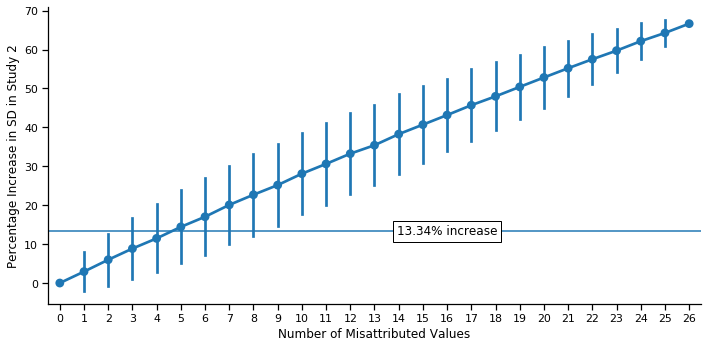

In [23]:
df_confus_s2 = (pd.DataFrame(data_confus_sd.T)/dists_s2["Med"].std())*100-100

df_confus_s2["Simulation"] = np.arange(df_confus_s2.shape[0])

df_confus_s2_long = pd.melt(df_confus_s2, id_vars=["Simulation"], var_name="n_confusion",
       value_name="sd")

g = sns.catplot(x="n_confusion", y="sd", data=df_confus_s2_long, aspect=2, kind="point", ci="sd")
g.ax.axhline(perc_sd_from_common)
g.ax.annotate(f"{perc_sd_from_common:.2f}% increase", (16, perc_sd_from_common), ha="center", va="center", bbox=dict(fc="white"))
g.set_xlabels("Number of Misattributed Values")
g.set_ylabels("Percentage Increase in SD in Study 2");

This suggests that at least 3 values would need to be swapped to generate this increase. 

2. Next, we estimate the "dispersion spillover" that three "swaps" would imply in study 8

In [28]:
scaling = df8["sd"].std(ddof=1)
data_confus_mean = np.array([[simulate_response(dists_s8, n_accur=25-j, n_confused=j, statfunc=np.std) for i in range(5000)] for j in [0, 3]]).mean(axis=1)
implied_size = data_confus_mean[1]/data_confus_mean[0] 
implied_d = (data_confus_mean[1]-data_confus_mean[0])/scaling

gb_stats = df8.groupby(["is_manipulated", "mean_manipulated"]).mean()["sd"]
observed_size = (gb_stats[(False, "High")] + gb_stats[(False, "Low")])/(gb_stats[(False, "Med")]*2)
observed_d = (gb_stats[(False, "High")]/2 + gb_stats[(False, "Low")]/2 - gb_stats[(False, "Med")])/scaling

common_resp_same = df8[(df8.is_manipulated == False) & (df8.mean_manipulated == "Med")]["sd"].values
common_resp_diff = df8[(df8.is_manipulated == False) & (df8.mean_manipulated != "Med")]["sd"].values

lr = lr_test(common_resp_same, common_resp_diff, d=observed_d, mu=0, two_sided=False)
decision = lr_test_decision(common_resp_diff, common_resp_same, implied_d, mu=0)

Markdown(
f"""
Our simulations show that if people misattribute three values from one distribution to the other, we should find 
that the perceived standard deviation increases by {implied_size*100-100:.2f}% when the two distributions have 
different (vs. identical) means (i.e., an effect size of d = {implied_d:.2f})

3. Finally, we compare this implied effect size to the observed effect. In Study 8, we observed a *reduction* of {np.abs(observed_size*100-100):.2f}% of the standard deviation when
the two distributions have different (vs. identical) means (i.e., an effect size of d = {observed_d:.2f}).

Again, a likelihood ratio test (Schnuerch and Erdfelder, 2020) suggests that the null is {(1/lr):.1f} times more likely than the implied effect.

We therefore accept the null with $\\alpha$ = .05 and $1-\\beta$ = .90
"""
)


Our simulations show that if people misattribute three values from one distribution to the other, we should find 
that the perceived standard deviation increases by 20.35% when the two distributions have 
different (vs. identical) means (i.e., an effect size of d = 0.45)

3. Finally, we compare this implied effect size to the observed effect. In Study 8, we observed a *reduction* of 9.65% of the standard deviation when
the two distributions have different (vs. identical) means (i.e., an effect size of d = -0.24).

Again, a likelihood ratio test (Schnuerch and Erdfelder, 2020) suggests that the null is 14.8 times more likely than the implied effect.

We therefore accept the null with $\alpha$ = .05 and $1-\beta$ = .90


# Supplementary Study (A1): Are Perceptions of Dispersion Only Driven by the Range?

## Design

Participants saw two distributions:

* Focal: Normal Distribution SD, $\sigma = 3.1$
* Manipulated: Normal Distribution, $\sigma = 3.1$ or Uniform, $\sigma = 4.6$.

The range was always equal across conditions

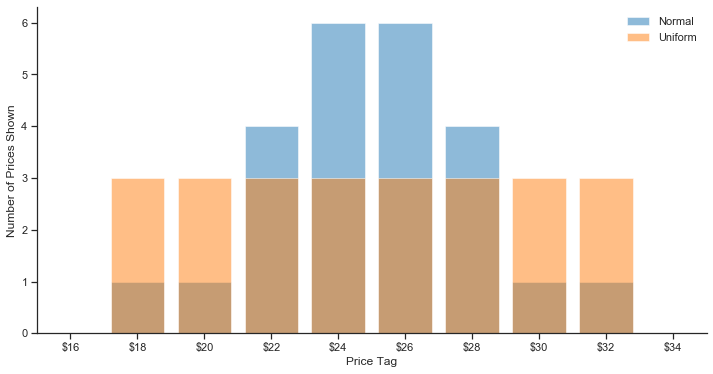

In [29]:
# fmt: off
dist_normal = [
    18,
    20,
    22, 22, 22, 22,
    24, 24, 24, 24, 24, 24,
    26, 26, 26, 26, 26, 26,
    28, 28, 28, 28, 
    30,
    32,
]

dist_uniform = [
    18, 18, 18,
    20, 20, 20,
    22, 22, 22,
    24, 24, 24,
    26, 26, 26,
    28, 28, 28,
    30, 30, 30,
    32, 32, 32,
]
# fmt: on

sns.set_style("ticks")
fig, ax = plt.subplots(1, figsize=(12, 6))
plt.hist(
    dist_normal,
    bins=np.arange(15, 35, 2),
    histtype="bar",
    alpha=0.5,
    label="Normal",
    rwidth=0.8,
)
plt.hist(
    dist_uniform,
    bins=np.arange(15, 35, 2),
    histtype="bar",
    alpha=0.5,
    label="Uniform",
    rwidth=0.8,
)
sns.despine()
ax.set_xlabel("Price Tag")
ax.set_ylabel("Number of Prices Shown")
ax.set_xticks(np.arange(16, 36, 2))
ax.set_xticklabels([f"${i}" for i in np.arange(16, 36, 2)])
ax.set_xlim(15, 35)
plt.legend(frameon=False);

The graph below shows the (mean-centered) distributions reported by participants:

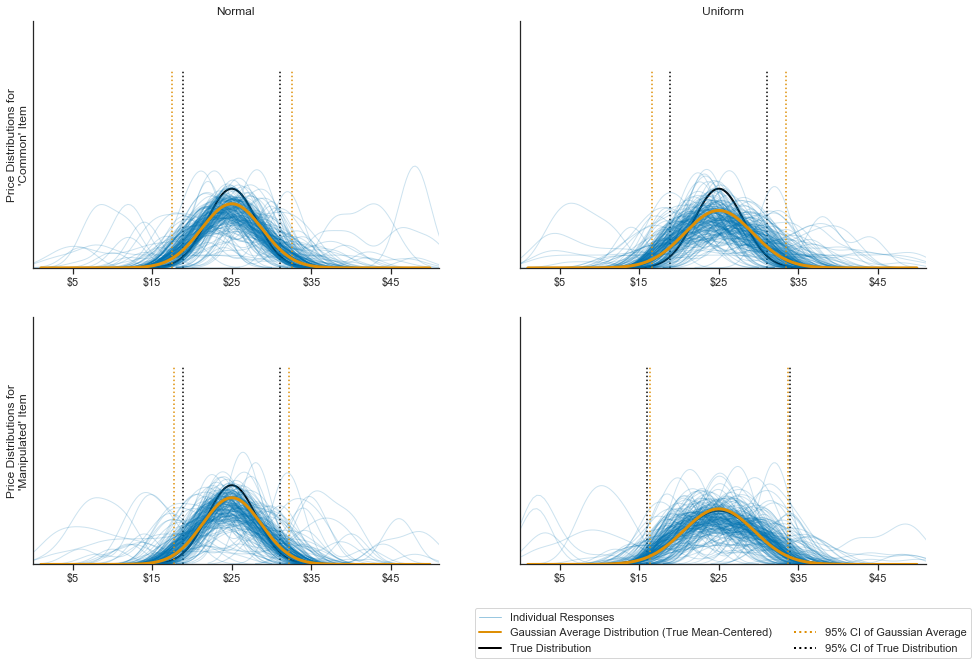

In [30]:
plot_disp_twocells(dfa1_dists)

## Analysis

### Descriptive statistics

Number of participants:

In [31]:
int(dfa1.shape[0] / 2)

395

### Characteristics of reported distributions

For each distribution reported by participants, we computed the following statistics of interest: 
* Mean
* Median
* Mode
* SD 
* Variance
* Interquartile Range (IQR)
* Minimum
* Maximum
* Kurtosis

We regressed those statistics on the following predictors:
* One factor indicating the type of the distribution (Dummy-coded: "Manipulated vs. Common")
* One factor indicating the amount of dispersion in the "Manipulated" distribution (Dummy-coded: "Uniform" vs. Normal")
* The interaction of those factors
* A random intercept for each participant

The conditional effects for each of the two categories (manipulated vs. common) are presented in the table below:

In [32]:
r = []
for depvar in ["mean", "median", "mode", "sd", "var", "iqr", "min", "max", "range", "kurtosis"]:
    c = smf.mixedlm(
        f"{depvar} ~ -1 + C(is_manipulated) + C(shape_manipulated, Treatment):C(is_manipulated)",
        dfa1,
        groups=dfa1.turkid,
    ).fit()
    r.append(c)


t = gen_output_from_models(
    r,
    ["Mean", "Median", "Mode", "SD", "Var", "IQR", "Min", "Max", "Range", "kurtosis"],
    [
        "Common: Normal",
        "Manipulated: Normal",
        "Common: Uniform vs. Normal",
        "Manipulated: Uniform vs. Normal",
        "Participants Random Effect Var",
    ],
)

ResultTableStyler(t)

Exposure to another distribution with more weight on the tail inflated people's perception of dispersion, and this effect is driven by a lower kurtosis: People put more weight on the tails of the distributions after learning a uniform (vs. normal) distribution.

Those two results confirm that people's perception of dispersion are sensitive to the overall dispersion of the distribution, and not simply to its range.

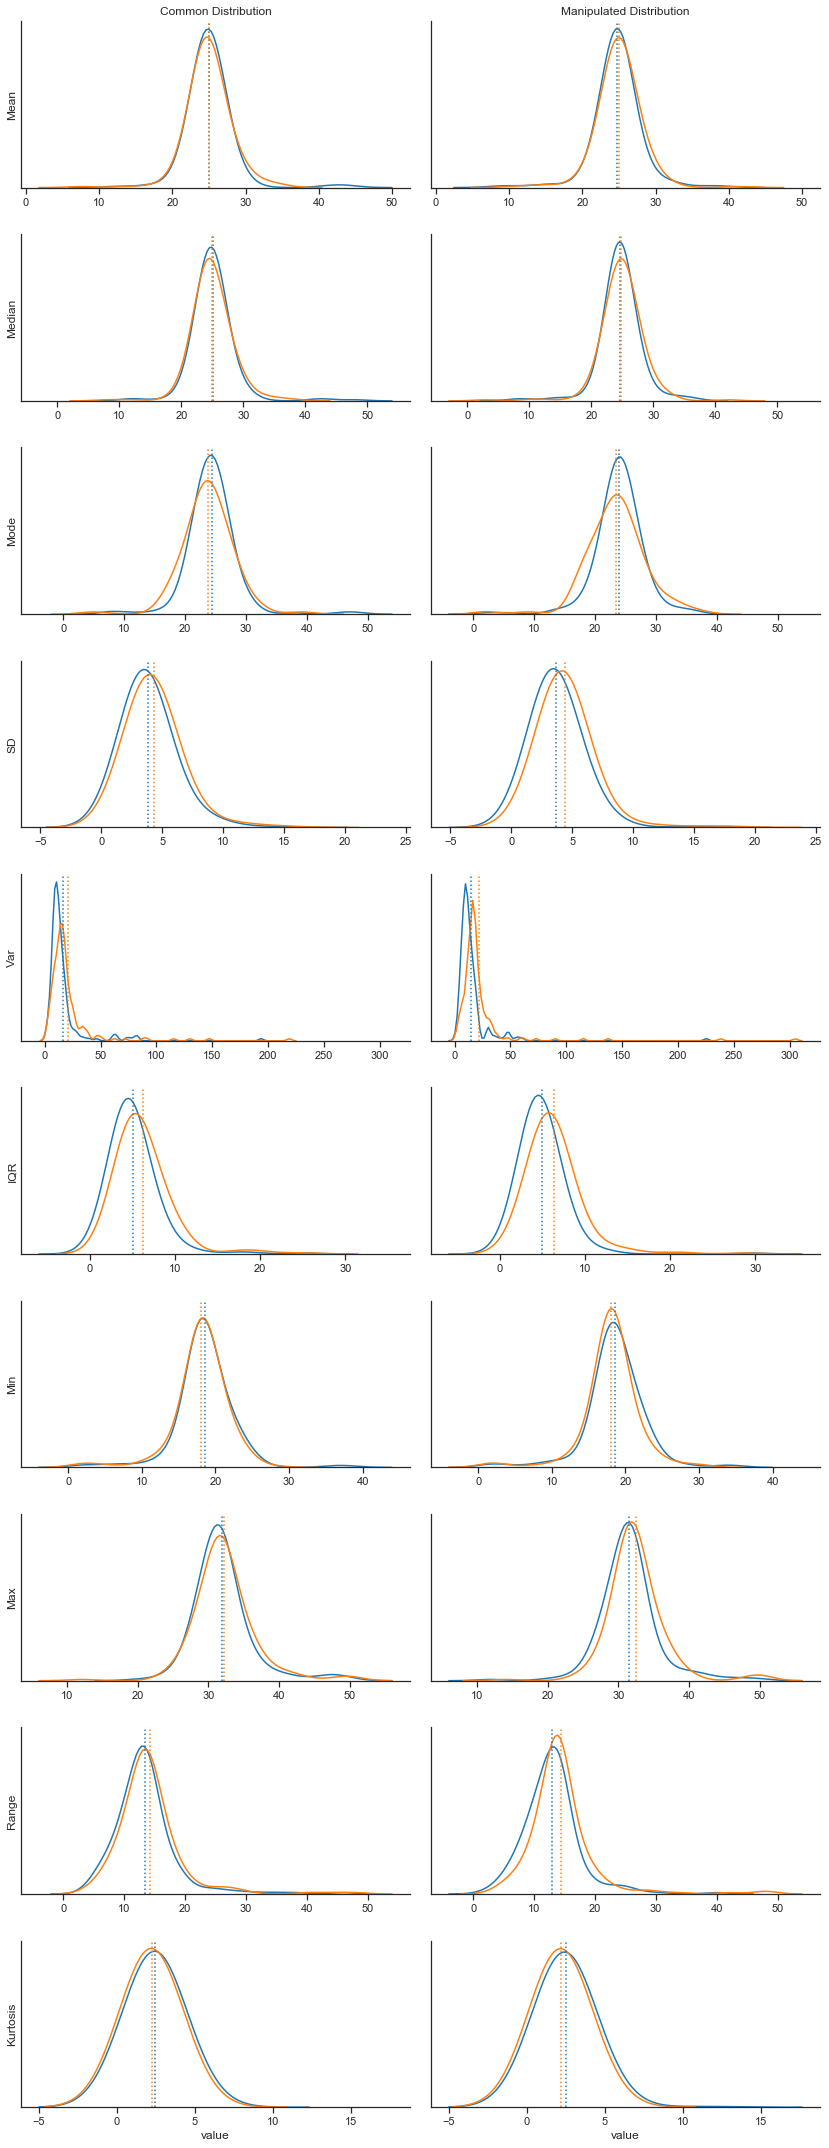

In [33]:
plot_stats_twocells(dfa1)

# How do People Construct Distributions?

## Descriptive Graph

In study 2, we recorded how people construct distributions over time.

The graph below visualizes four clusters of "construction strategy".

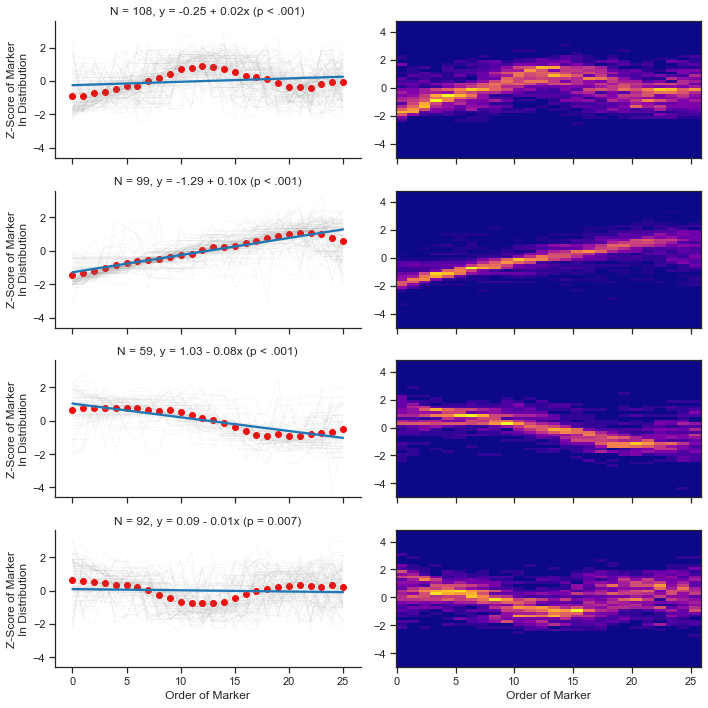

In [34]:
# Constructing the history data
data = []
for p in df2_hist.pid.unique()[0:]:
    for k in [False, True]:
        d = df2_hist[(df2_hist.pid == p) & (df2_hist.is_manipulated == k)].copy()
        v = d.value.values
        if len(v) != 0:
            data.append(v)
data = np.array(data)

# Standardizing the data before clustering
data_std = data.T

data_std = (data_std - np.mean(data_std, axis=0)) / np.std(data_std, axis=0)
isnan = np.isnan(data_std).max(axis=0)
data_std = data_std[:, ~isnan].T

# Clustering and aggregating
p = KernelPCA(25, kernel="linear").fit(data_std)
dnew = p.transform(data_std)
N_CLUSTERS = 4
kmeans = KMeans(init="k-means++", n_clusters=N_CLUSTERS, n_init=10)
kmeans.fit(dnew)
clusters = kmeans.predict(dnew)

# Plotting
fig, ax = plt.subplots(N_CLUSTERS, 2, figsize=(10, 10), sharex="col", sharey="col")
for i, c in enumerate(np.unique(clusters)):
    d = data_std[clusters == c]
    r = d.shape[0]
    x = np.repeat(np.arange(0, 26, 1), r)
    y = d.T.flatten()
    mod = OLS(y, add_constant(x)).fit()
    _, _, _, cs = ax[i][1].hist2d(
        np.tile(np.arange(0, 26, 1), r),
        (d).flatten(),
        bins=[np.arange(0, 27, 1) - 0.1, np.arange(-5, 5, .2)],
        cmap="plasma",
        normed=True,
    )
    ax[i][0].scatter(np.arange(0, 26, 1), d.mean(axis=0), color="r")
    for indiv in d[::]: 
        ax[i][0].plot(np.arange(0, 26, 1), indiv, lw=.5, color="grey", alpha=0.1)
    sns.regplot(x, y, scatter_kws={"alpha": 0.1}, scatter=False, ax=ax[i][0])
    sign = "+" if mod.params[1] > 0 else "-"
    pval = mod.pvalues[1]
    ptext = f"(p = {pval:.3f})" if pval > 0.001 else "(p < .001)"
    ax[i][0].set_title(
        f"N = {r}, y = {mod.params[0]:.2f} {sign} {np.abs(mod.params[1]):.2f}x {ptext}"
    )
    ax[i][0].set_ylabel("Z-Score of Marker\nIn Distribution")
    sns.despine(ax=ax[i][0])
ax[3][0].set_xlabel("Order of Marker")
ax[3][1].set_xlabel("Order of Marker")
ax[3][1].set_xlabel("Order of Marker")
plt.tight_layout()

Participants overall start from the left of the distribution builder, and work their way to the right.

## Construction Strategies and Accuracy 

We do not find that construction strategy (measured for instance as the ordinal position of the first market in the final distribution) is predictive of the accuracy of the final distribution.

### Ordinal Position of First Marker

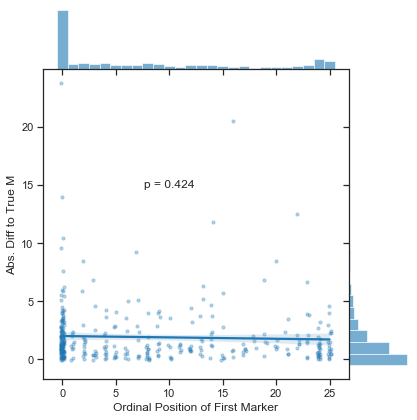

In [35]:
g = sns.JointGrid(x="idx_first_value", y="abs_diff_m", space=0, data=df2_parts)
g.plot_joint(
    sns.regplot, scatter_kws=dict(s=10, alpha=0.3), x_jitter=0.15, y_jitter=0.1
)
g.plot_joint(annotate_reg_coeff, pos=(10, 15))
g.ax_marg_x.hist(
    df2_parts["idx_first_value"], alpha=0.6, bins=np.arange(0, 27, 1), align="left"
)
g.ax_marg_y.hist(
    df2_parts["abs_diff_m"],
    alpha=0.6,
    orientation="horizontal",
    align="left",
    bins=np.arange(0, 20, 1),
)
g.set_axis_labels("Ordinal Position of First Marker", "Abs. Diff to True M");

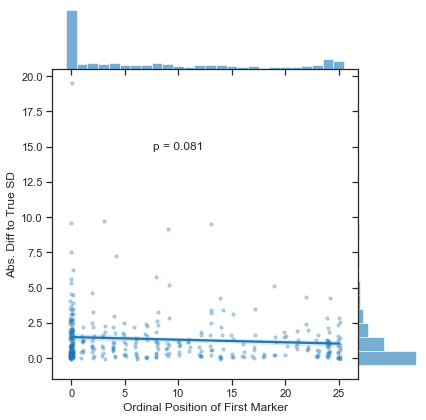

In [36]:
g = sns.JointGrid(x="idx_first_value", y="abs_diff_sd", space=0, data=df2_parts)
g.plot_joint(
    sns.regplot, scatter_kws=dict(s=10, alpha=0.3), x_jitter=0.15, y_jitter=0.1
)
g.plot_joint(annotate_reg_coeff, pos=(10, 15))
g.ax_marg_x.hist(
    df2_parts["idx_first_value"], alpha=0.6, bins=np.arange(0, 27, 1), align="left"
)
g.ax_marg_y.hist(
    df2_parts["abs_diff_sd"],
    alpha=0.6,
    orientation="horizontal",
    align="left",
    bins=np.arange(0, 20, 1),
)
g.set_axis_labels("Ordinal Position of First Marker", "Abs. Diff to True SD");

### Z-Score of First Marker

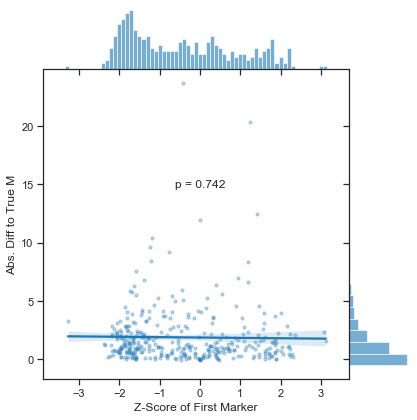

In [37]:
g = sns.JointGrid(x="zscore_first_value", y="abs_diff_m", space=0, data=df2_parts)
g.plot_joint(
    sns.regplot, scatter_kws=dict(s=10, alpha=0.3), x_jitter=0, y_jitter=0.1
)
g.plot_joint(annotate_reg_coeff, pos=(0, 15))
g.ax_marg_x.hist(
    df2_parts["zscore_first_value"], alpha=0.6, bins=np.arange(-3.5, 3.5, .1), align="left"
)
g.ax_marg_y.hist(
    df2_parts["abs_diff_m"],
    alpha=0.6,
    orientation="horizontal",
    align="left",
    bins=np.arange(0, 25, 1),
)
g.set_axis_labels("Z-Score of First Marker", "Abs. Diff to True M");

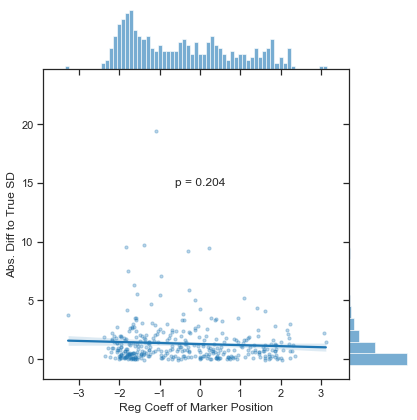

In [38]:
g = sns.JointGrid(x="zscore_first_value", y="abs_diff_sd", space=0, data=df2_parts)
g.plot_joint(
    sns.regplot, scatter_kws=dict(s=10, alpha=0.3), x_jitter=0, y_jitter=0.1
)
g.plot_joint(annotate_reg_coeff, pos=(0, 15))
g.ax_marg_x.hist(
   df2_parts["zscore_first_value"], alpha=0.6, bins=np.arange(-3.5, 3.5, .1), align="left"
)
g.ax_marg_y.hist(
    df2_parts["abs_diff_sd"],
    alpha=0.6,
    orientation="horizontal",
    align="left",
    bins=np.arange(0, 25, 1),
)
g.set_axis_labels("Reg Coeff of Marker Position", "Abs. Diff to True SD");

### Regression Coefficient between Marker Order and Marker Z-Score

(A positive coefficient indicates that the distribution is constructed mostly left-to-right, a negative coefficient mostly right-to-left)

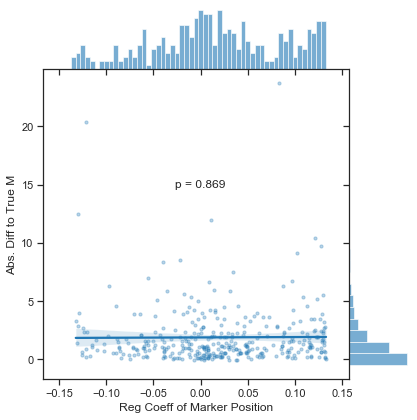

In [39]:
g = sns.JointGrid(x="reg_coeff_order", y="abs_diff_m", space=0, data=df2_parts)
g.plot_joint(
    sns.regplot, scatter_kws=dict(s=10, alpha=0.3), x_jitter=0, y_jitter=0.1
)
g.plot_joint(annotate_reg_coeff, pos=(0, 15))
g.ax_marg_x.hist(
    df2_parts["reg_coeff_order"], alpha=0.6, bins=np.arange(-.15, .15, .005), align="left"
)
g.ax_marg_y.hist(
    df2_parts["abs_diff_m"],
    alpha=0.6,
    orientation="horizontal",
    align="left",
    bins=np.arange(0, 25, 1),
)
g.set_axis_labels("Reg Coeff of Marker Position", "Abs. Diff to True M");

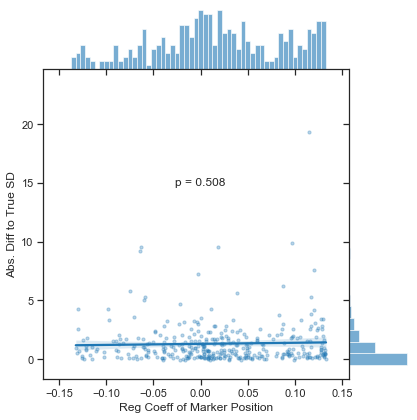

In [40]:
g = sns.JointGrid(x="reg_coeff_order", y="abs_diff_sd", space=0, data=df2_parts)
g.plot_joint(
    sns.regplot, scatter_kws=dict(s=10, alpha=0.3), x_jitter=0, y_jitter=0.1
)
g.plot_joint(annotate_reg_coeff, pos=(0, 15))
g.ax_marg_x.hist(
    df2_parts["reg_coeff_order"], alpha=0.6, bins=np.arange(-.15, .15, .005), align="left"
)
g.ax_marg_y.hist(
    df2_parts["abs_diff_sd"],
    alpha=0.6,
    orientation="horizontal",
    align="left",
    bins=np.arange(0, 25, 1),
)
g.set_axis_labels("Reg Coeff of Marker Position", "Abs. Diff to True SD");